# Demonstrator notebook
This notebook demonstrates the methods and results from the study:
`"Evaluation of a novel approach to partitioning respiration and photosynthesis using eddy covariance, wavelets, and conditional sampling"
by Pedro H. H. Coimbra, Benjamin Loubet, Olivier Laurent, Matthias Mauder, Bernard Heinesch, Jonathan Bitton, Nicolas Delpierre, Daniel Berveiller, Jérémie Depuydt, and Pauline Buysse (DOI:10.1016/j.agrformet.2025.110684).`

[![DOI](https://zenodo.org/badge/DOI/10.1016/j.agrformet.2025.110684.svg)](https://doi.org/10.1016/j.agrformet.2025.110684)


# Demonstration

In [1]:
import os
from functools import reduce
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.dates import AutoDateFormatter
from matplotlib.patches import ConnectionPatch
from matplotlib.dates import DateFormatter
import string

if 'current_file_folder' not in globals():
    current_file_folder = os.getcwd()
os.chdir(current_file_folder+'/../..')
import waveletec as wEC
from waveletec._core import j2sj
if 'current_file_folder' in globals(): os.chdir(current_file_folder)

def init(data, X):
    result = {}
    raw_data = data.interpolate().dropna(axis=1, how='all').dropna()
    result['data'] = raw_data.copy()

    X = [v for v in X if v in raw_data]
    if not X:
        return None
    
    for v in X:
        this = wEC.wavelet_transform(raw_data[v].to_list(), 'dwt', wavelet='db6', fs=20, f0=1/(.5*60*60), f1=10, fn=180,
                                            dj=1/12)
        result[v] = this.wave
    result['sj'] = this.sj
    return type('var_', (object,), result)


def get_rawdata(path):
    data = pd.read_csv(path, skiprows=9, sep='\s+', engine='python', na_values=[-9999, 'NAN'])
    data['TIMESTAMP'] = path.split('/')[-1].split('_')[0].split('.')[0]
    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'], format='%Y%m%d-%H%M')
    return data


def highlight(data, date="2022-05-13 15:30:00"):
    data = data.copy()
    date = pd.to_datetime(date)
    data = data.query(f'TIMESTAMP == "{date}"')
    # data = highlight_data[16000 : 20000]
    data = data.reset_index(drop=True)
    data.index += 16000
    return type('var_', (object,), {'data': data, 'date': date})

<>:36: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:36: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
/tmp/ipykernel_32669/3167901925.py:36: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
  data = pd.read_csv(path, skiprows=9, sep='\s+', engine='python', na_values=[-9999, 'NAN'])


In [2]:
corrraw_data = (reduce(lambda left, right: pd.concat([left, right]),
                       [get_rawdata(f'{current_file_folder}/output/eddypro_raw_datasets/level_6/{f}')
                       for f in os.listdir(f'{current_file_folder}/output/eddypro_raw_datasets/level_6/')[:]]))
corrraw_data['TIMESTAMP_ns'] = corrraw_data['TIMESTAMP'] + \
    corrraw_data.index * pd.to_timedelta('0.05s')
corrraw_data = corrraw_data.reset_index(drop=True)
corrraw_data['h2o'] = corrraw_data['h2o'] * 1000  # convert to mmol/m2/s?
for v in ['w', 'ts', 'co2', 'h2o']:
    corrraw_data[v +
                 '_'] = corrraw_data.groupby('TIMESTAMP')[v].transform(np.nanmean)

In [3]:
wl_data = init(corrraw_data, ['co2', 'w', 'ts', 'h2o'])

In [4]:
common_data = wl_data.data.copy()
fs = [1/j2sj(j_, 20) for j_ in wl_data.sj]
f30 = len([j_ for j_ in wl_data.sj if j_ < 14.13575])

common_data['wl_w'] = np.nansum(wl_data.w, 0)
common_data['wl_co2'] = np.nansum(wl_data.co2, 0)
common_data['wl_h2o'] = np.nansum(wl_data.h2o, 0)
common_data['wl_w_'] = np.nansum(wl_data.w[f30:], 0)
common_data['wl_co2_'] = np.nansum(wl_data.co2[f30:], 0)
common_data['wl_h2o_'] = np.nansum(wl_data.h2o[f30:], 0)
common_data['wl_wco2'] = np.nansum(
    (wl_data.w * wl_data.co2)[:f30], 0)
common_data['wl_wh2o'] = np.nansum(
    (wl_data.w * wl_data.h2o)[:f30], 0)

In [7]:
# wEC.main(wl_data.data, ['w*co2|w*h2o'], method='dwt', wavelet='db6', fs=20, f0=1/(.5*60*60), f1=10,
#          fn=180, dj=1/12, output_kwargs={'output_path': 'output/wavelet_flux/00000_full_cospectra_{}.csv'})

wEC.run_from_eddypro("input/EP/FR-Gri_sample.eddypro", 
                     input_path="output/eddypro_raw_datasets/level_6", 
                     output_folderpath='output/wavelet_flux')


RUNNING WAVELET TRASNFORM (dwt)

 20220513 reading           
 20220514 reading           
 20220515 reading           
 20220516 reading           


,TIMESTAMP,natural_frequency,variable,value
0,2022-05-13 00:00:00,0.000038,co2,427.493272
1,2022-05-13 00:00:00,0.000076,co2,-0.465488
2,2022-05-13 00:00:00,0.000153,co2,-0.584151
3,2022-05-13 00:00:00,0.000305,co2,0.939468
4,2022-05-13 00:00:00,0.000610,co2,0.455876
...,...,...,...,...
10939,2022-05-15 23:30:00,0.625000,wts+wh2o-,0.000464
10940,2022-05-15 23:30:00,1.250000,wts+wh2o-,0.000539
10941,2022-05-15 23:30:00,2.500000,wts+wh2o-,0.000384
10942,2022-05-15 23:30:00,5.000000,wts+wh2o-,0.000245


## Basics

Reynolds decomposition (conventional EC)

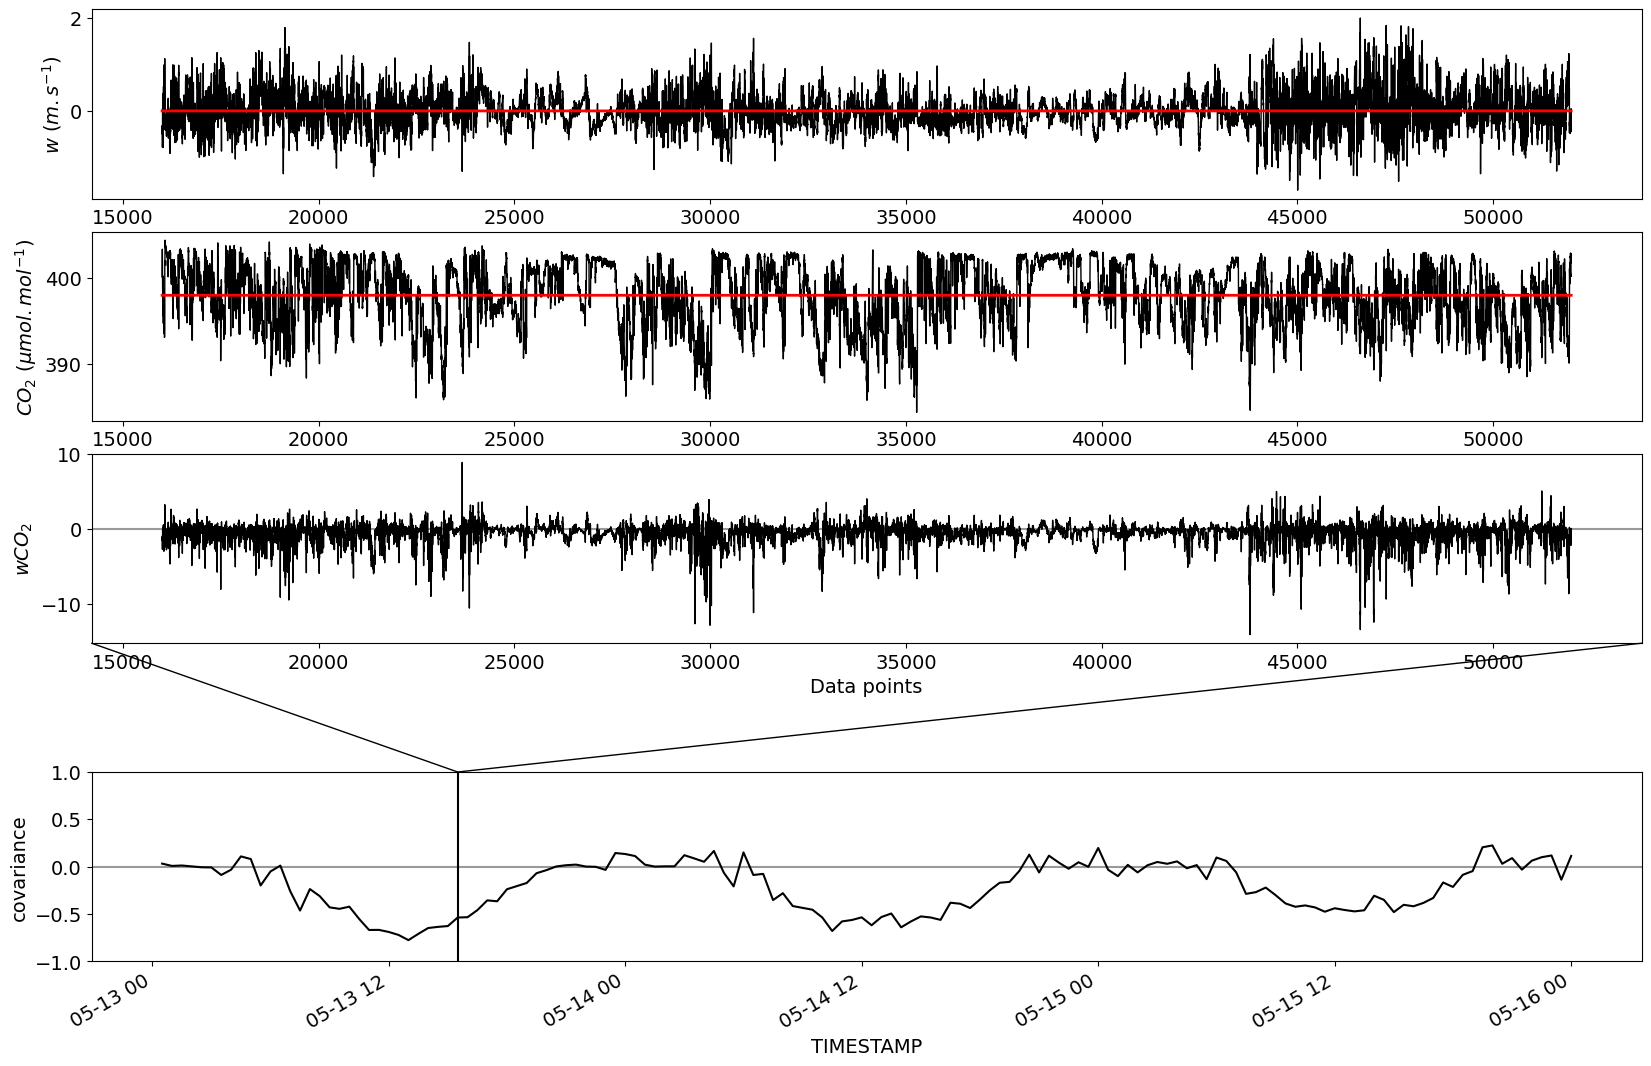

In [8]:
plt.rcParams.update({'font.size': 14})

this = highlight(common_data)
this_data = this.data
this_date = this.date

plt.subplots(5,1, figsize=(20,14), gridspec_kw={'height_ratios': [3,3,3,1,3]})

plt.subplot(511)
plt.plot(this_data['w'], label='observed', c='k', lw=1)
plt.plot(this_data['w_'], label='mean', c='red', ls='-', lw=2)
plt.ylabel(r'$w$ ($m.s^{-1}$)')

plt.subplot(512)
plt.plot(this_data['co2'], label='observed', c='k', lw=1)
plt.plot(this_data['co2_'], label='mean', c='red', ls='-', lw=2)
plt.ylabel(r'$CO_2$ ($μmol.mol^{-1}$)')

plt.subplot(513)
plt.axhline(0, c='.60')
plt.plot((this_data['w'] - this_data['w_']) *
         (this_data['co2'] - this_data['co2_']), c='k', lw=1)
plt.ylabel(r'$wCO_2$')
plt.xlabel('Data points')
lastax = plt.gca()

plt.subplot(514)
plt.gca().axis('off')

plt.subplot(515)
plt.axhline(0, c='.60')
plt.axvline(this_date, c='k')
# assuming density of dry air ~ 42 mol/m3 
common_data.groupby('TIMESTAMP').apply(lambda row: pd.Series({'covariance': np.cov(row['w'], row['co2'])[0][1]})).reset_index(drop=False).plot(
    x='TIMESTAMP', ax=plt.gca(), c='k')
plt.ylabel('covariance')
plt.legend().remove()
plt.ylim(-1, 1)

from matplotlib.patches import ConnectionPatch
con = ConnectionPatch(xyA=(this_date, plt.gca().get_ylim()[1]), xyB=(0, 0), coordsA="data", coordsB="axes fraction",
                      axesA=plt.gca(), axesB=lastax, color="k")
plt.gca().add_artist(con)
con = ConnectionPatch(xyA=(this_date, plt.gca().get_ylim()[1]), xyB=(1, 0), coordsA="data", coordsB="axes fraction",
                      axesA=plt.gca(), axesB=lastax, color="k")
plt.gca().add_artist(con)

plt.show()

avg x low freq.

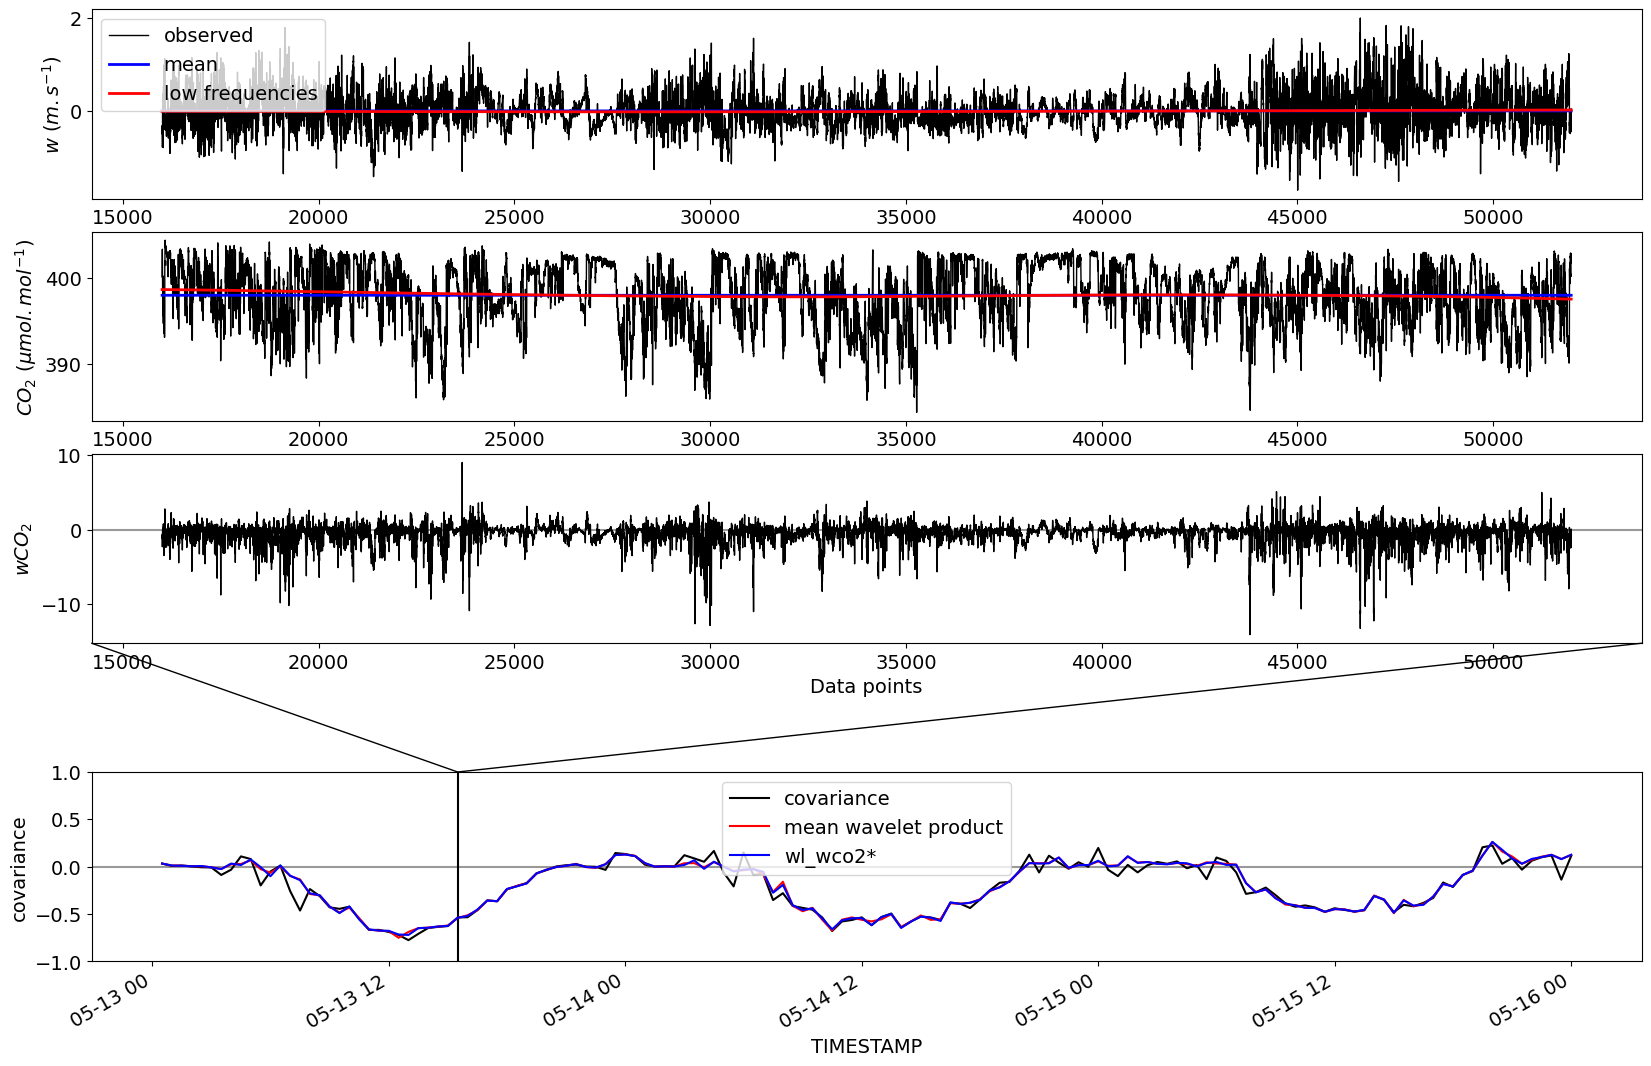

In [9]:
plt.rcParams.update({'font.size': 14})

this_data = common_data.copy()
this_data['wl_wco2*'] = (this_data.w - this_data.wl_w_) * \
    (this_data.co2 - this_data.wl_co2_)

this = highlight(this_data)
this_data_ = this.data
this_date = this.date

plt.subplots(5,1, figsize=(20,14), gridspec_kw={'height_ratios': [3,3,3,1,3]})

plt.subplot(511)
plt.plot(this_data_['w'], label='observed', c='k', lw=1)
plt.plot(this_data_['w_'], label='mean', c='blue', ls='-', lw=2)
plt.plot(this_data_['wl_w_'], label='low frequencies', c='red', ls='-', lw=2)
plt.legend()
plt.ylabel(r'$w$ ($m.s^{-1}$)')

plt.subplot(512)
plt.plot(this_data_['co2'], label='observed', c='k', lw=1)
plt.plot(this_data_['co2_'], label='mean', c='blue', ls='-', lw=2)
plt.plot(this_data_['wl_co2_'], label='low frequencies', c='red', ls='-', lw=2)
plt.ylabel(r'$CO_2$ ($μmol.mol^{-1}$)')

plt.subplot(513)
plt.axhline(0, c='.60')
plt.plot((this_data_['wl_w'] - this_data_['wl_w_']) *
         (this_data_['wl_co2'] - this_data_['wl_co2_']), c='k', lw=1)
plt.ylabel(r'$wCO_2$')
plt.xlabel('Data points')
lastax = plt.gca()

plt.subplot(514)
plt.gca().axis('off')

plt.subplot(515)
plt.axhline(0, c='.60')
plt.axvline(this_date, c='k')
# assuming density of dry air ~ 42 mol/m3 
this_data.groupby('TIMESTAMP').apply(lambda row: pd.Series({'covariance': np.cov(row['w'], row['co2'])[0][1]})).reset_index(drop=False).plot(
    x='TIMESTAMP', ax=plt.gca(), c='k')
this_data.groupby('TIMESTAMP')['wl_wco2'].agg(np.nanmean).reset_index(drop=False).rename(columns={'wl_wco2': 'mean wavelet product'}).plot(
    x='TIMESTAMP', ax=plt.gca(), c='red')
this_data.groupby('TIMESTAMP')['wl_wco2*'].agg(np.nanmean).reset_index(drop=False).rename(columns={'wl_wco2': 'mean wavelet product'}).plot(
    x='TIMESTAMP', ax=plt.gca(), c='blue')
plt.ylabel('covariance')
plt.legend()
plt.ylim(-1, 1)

from matplotlib.patches import ConnectionPatch
con = ConnectionPatch(xyA=(this_date, plt.gca().get_ylim()[1]), xyB=(0, 0), coordsA="data", coordsB="axes fraction",
                      axesA=plt.gca(), axesB=lastax, color="k")
plt.gca().add_artist(con)
con = ConnectionPatch(xyA=(this_date, plt.gca().get_ylim()[1]), xyB=(1, 0), coordsA="data", coordsB="axes fraction",
                      axesA=plt.gca(), axesB=lastax, color="k")
plt.gca().add_artist(con)

plt.show()

### Attenuation

We can represent attenuation by removing the high frequency from the signal.

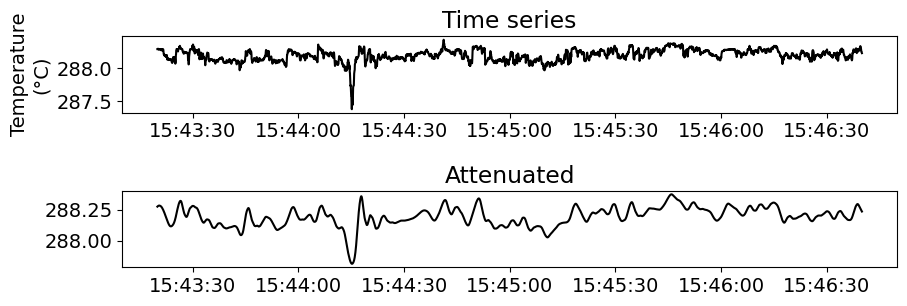

In [10]:
plt.rcParams.update({'font.size': 14})

subp = plt.subplots(3, 1, figsize=(10, 3), gridspec_kw={
                    'height_ratios': [3, 2, 3]})
jmin = 5
jmax = None

this = highlight(common_data)
this_data = this.data[16000: 20000]
this_date = this.date

for i, ax in enumerate(subp[1]):
    if i==0: 
        # ax.plot(this_data.TIMESTAMP_ns, this_data['co2'], label='observed', c='0')
        ax.plot(this_data.TIMESTAMP_ns, np.nansum(
            wl_data.ts[:, this_data.index], 0), label='decomposed', c='0')
        ax.set_title('Time series')
        ax.set_ylabel('Temperature\n(°C)')
    elif i == 1: ax.axis('off')
    else: 
        ax.plot(this_data.TIMESTAMP_ns, np.nansum(
            wl_data.ts[jmin:jmax, this_data.index], 0), label='decomposed', c='0')
        ax.set_title('Attenuated')
        ax.set_ylabel('')
    

### Decomposition

A signal is composed of different frequencies and we visualize them in different ways.

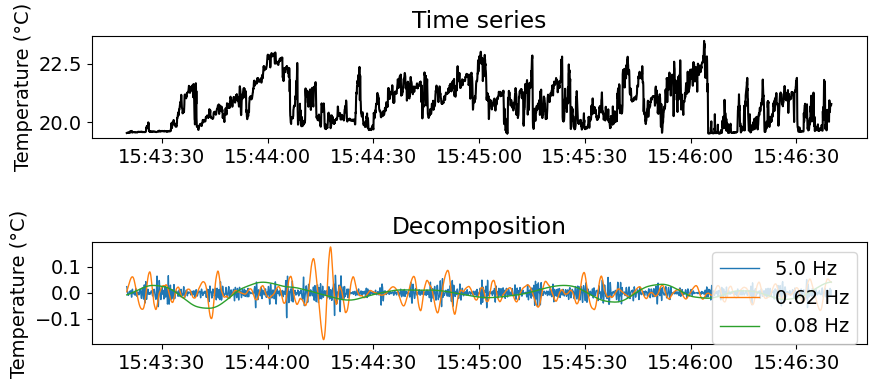

In [11]:
plt.rcParams.update({'font.size': 14})

imax = 10
if imax > len(wl_data.sj):
    imax = len(wl_data.sj)
subp = plt.subplots(3, 1, figsize=(10,4), gridspec_kw={'height_ratios': [3,2,3]})

this = highlight(common_data)
this_data = this.data[16000: 20000]
this_date = this.date

for i, ax in enumerate(subp[1]):
    if i > imax+2: 
        ax.axis('off')
        continue
    if i==0: 
        ax.plot(this_data.TIMESTAMP_ns,
                this_data['ts']-272.15, label='observed', c='0')
        ax.set_title('Time series')
        ax.set_ylabel('Temperature (°C)')
    elif (i == 1) or (i+2 == len(subp[1])) or (i-1 == imax): ax.axis('off')
    else:
        if i == 2: ax.set_title('Decomposition')
        ax.set_ylabel('Temperature (°C)')
        for s in range(2, 10, len(wl_data.ts)//5):
            ax.plot(this_data.TIMESTAMP_ns, wl_data.ts[s, this_data.index], lw=1, label=str(
                round(20*2**-s, 2))+' Hz')
        # ax.plot(this_data[0:2**i].TIMESTAMP_ns, wl_data.ts[i-2, this_data.index][0:2**i], c='0')
plt.legend()

as multiple sub-signals

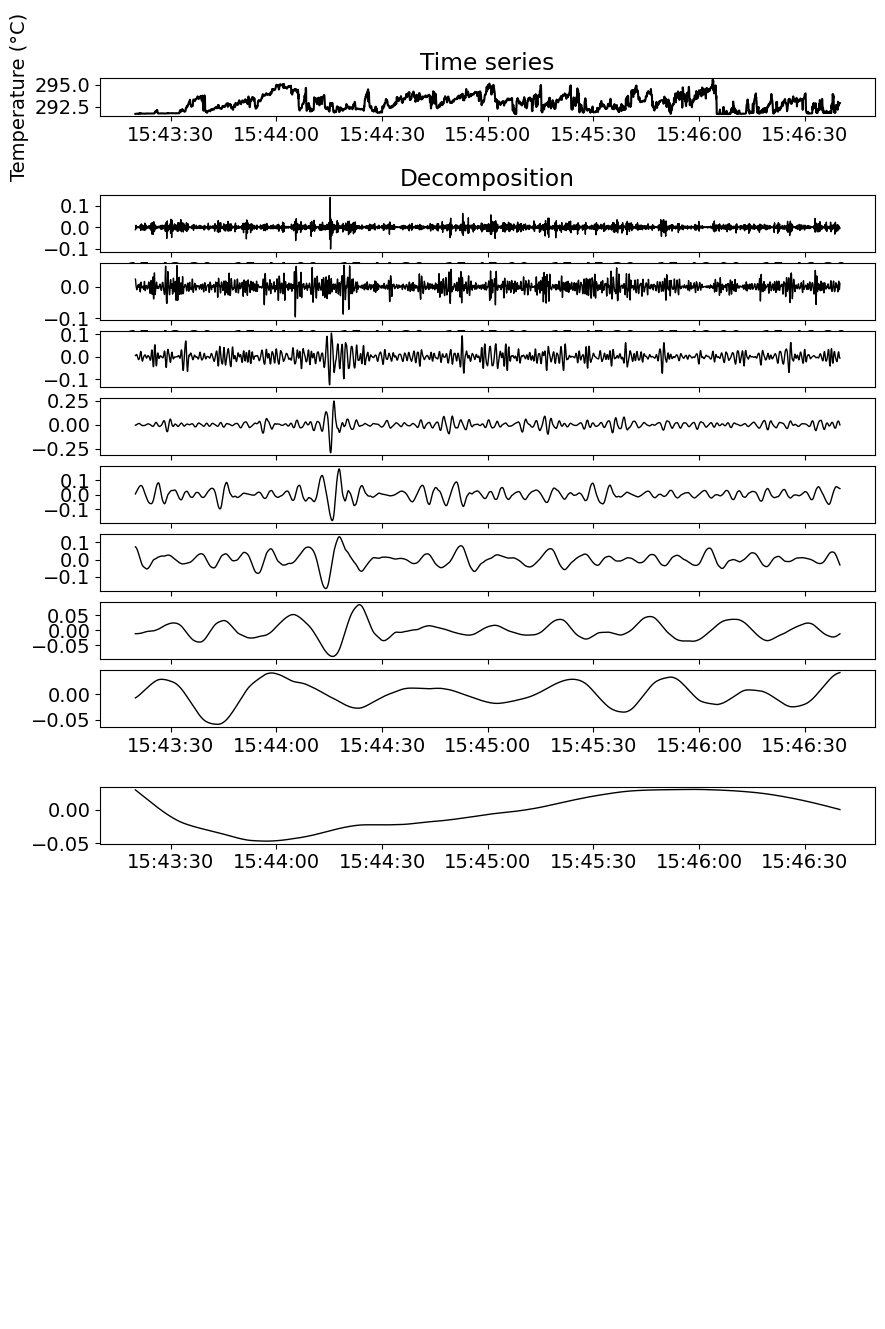

In [12]:
plt.rcParams.update({'font.size': 14})

imax = 10
if imax > len(wl_data.sj):
    imax = len(wl_data.sj)
h_ratio = [3, 2] + [3]*(len(wl_data.sj)+1)
h_ratio[imax+1] = 2
subp = plt.subplots(len(wl_data.sj)+3, 1, figsize=(10, 17),
                    gridspec_kw={'height_ratios': h_ratio})

this = highlight(common_data)
this_data = this.data[16000: 20000]
this_date = this.date

for i, ax in enumerate(subp[1]):
    if i == 0:
        ax.axis('off')
        continue
    if i > imax+2:
        ax.axis('off')
        continue
    if i==1: 
        ax.plot(this_data.TIMESTAMP_ns,
                this_data['ts'], label='observed', c='0')
        ax.set_title('Time series')
        ax.set_ylabel('Temperature (°C)')
    elif (i == 2) or (i+2 == len(subp[1])) or (i-1 == imax): ax.axis('off')
    elif (i == imax+3):
        ax.set_title('Lowest frequency')
        ax.plot(this_data.TIMESTAMP_ns, np.nansum(
            wl_data.ts[i-3:, this_data.index], 0), label='decomposed', c='0')
    else:
        if i == 3: ax.set_title('Decomposition')
        ax.plot(this_data.TIMESTAMP_ns,
                wl_data.ts[i-2, this_data.index], label='decomposed', lw=1, c='0')
        # ax.plot(this_data[0:2**i].TIMESTAMP_ns, wl_data.ts[i-2, this_data.index][0:2**i], c='0')

as a cospectra

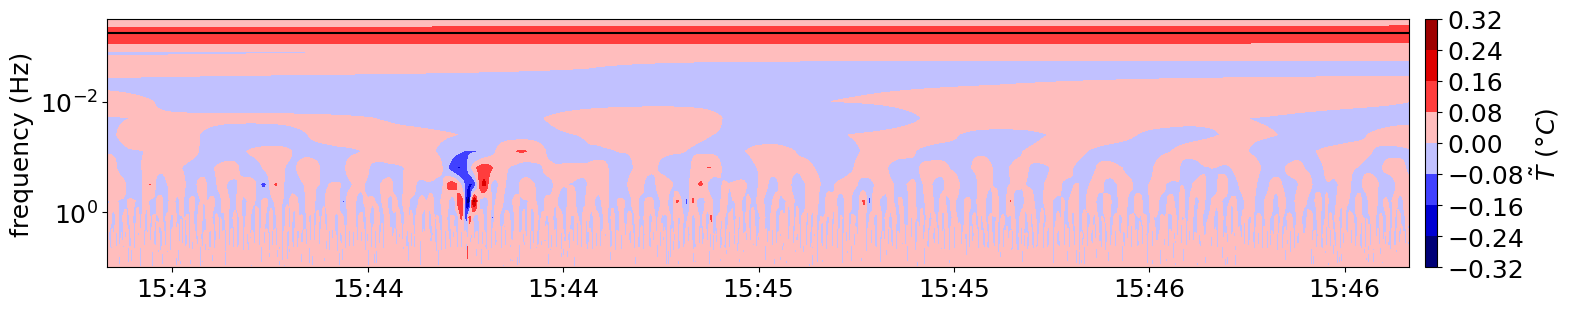

In [13]:
plt.rcParams.update({'font.size': 18})

this = highlight(common_data)
this_data = this.data[16000: 20000]
this_date = this.date

fs = [1/j2sj(j_, 20) for j_ in wl_data.sj]
Xi, Yi = np.meshgrid(this_data.TIMESTAMP_ns.values, fs)

plt.figure(figsize=(20,3*14/13))

plt.axhline(1/(60*60*.5), c='k')
plt.contourf(Xi[:-1], Yi[:-1], wl_data.ts[:-1,
             this_data.index], cmap=plt.cm.seismic)
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('frequency (Hz)')
plt.colorbar(pad=0.01).set_label(r"$\~T$ ($°C$)", rotation=90)

### 20Hz to 30min *(in time-scale)*

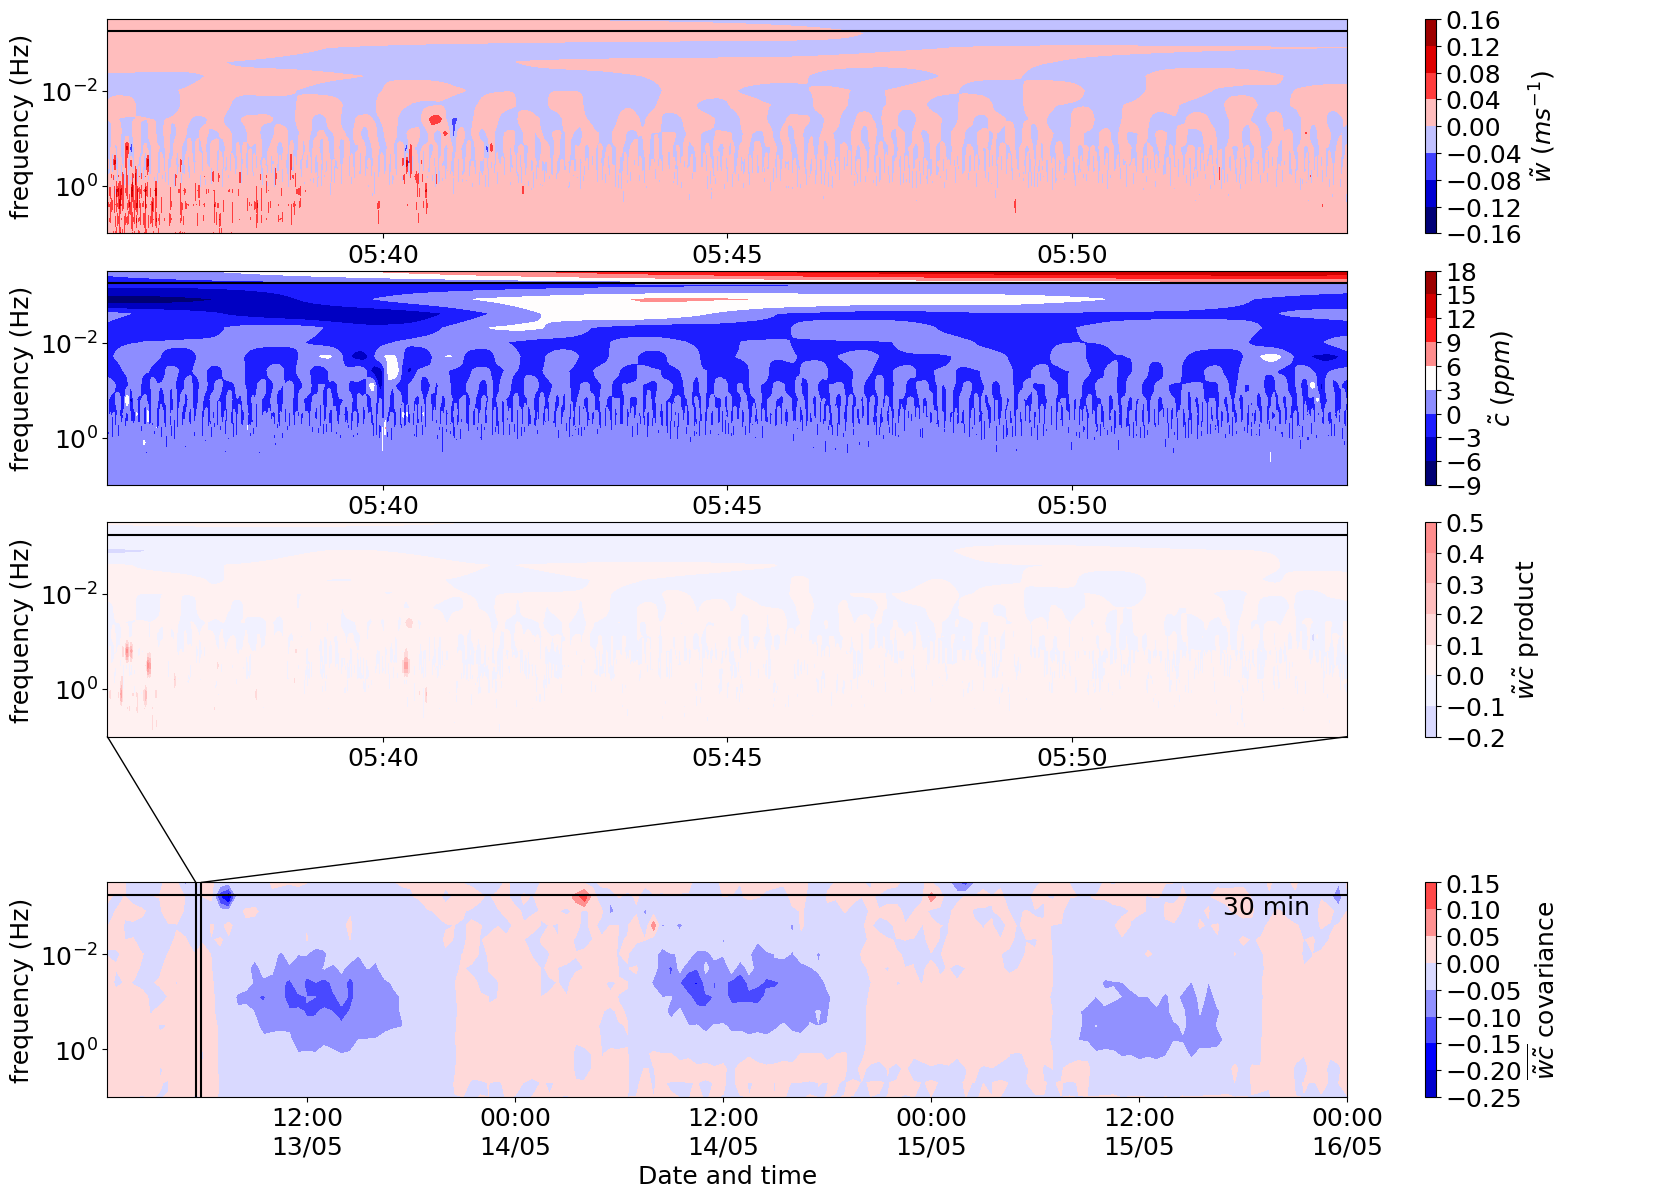

In [14]:
plt.rcParams.update({'font.size': 18})

this_data = common_data.copy()
fs = [1/j2sj(j_, 20) for j_ in wl_data.sj]
Xi, Yi = np.meshgrid(this_data.TIMESTAMP_ns.values, fs)

plt.subplots(5,1, figsize=(20,14), gridspec_kw={'height_ratios': [3,3,3,1,3]})
i0 = 10.2
i1 = 10.8

plt.subplot(511)
plt.axhline(1/(60*60*.5), c='k')
plt.contourf(Xi[:-1, int(i0*36000):int(i1*36000)], Yi[:-1, int(i0*36000):int(i1*36000)],
             wl_data.w[:-1, int(i0*36000):int(i1*36000)], cmap=plt.cm.seismic)
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('frequency (Hz)')
plt.colorbar().set_label(r"$\~w$ ($ms^{-1}$)", rotation=90)

plt.subplot(512)
plt.axhline(1/(60*60*.5), c='k')
plt.contourf(Xi[:-1, int(i0*36000):int(i1*36000)], Yi[:-1, int(i0*36000):int(i1*36000)],
             wl_data.co2[:-1, int(i0*36000):int(i1*36000)], cmap=plt.cm.seismic)
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('frequency (Hz)')
plt.colorbar().set_label(r"$\~c$ ($ppm$)", rotation=90)

plt.subplot(513)
Zi = (wl_data.w * wl_data.co2)
plt.axhline(1/(60*60*.5), c='k')
plt.contourf(Xi[:-1, int(i0*36000):int(i1*36000)], Yi[:-1, int(i0*36000):int(i1*36000)], Zi[:-1, int(i0*36000):int(i1*36000)], 
             vmin=-2, vmax=2, cmap=plt.cm.seismic)
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('frequency (Hz)')
plt.colorbar().set_label(r"$\~w\~c$ product")
lastax = plt.gca()

plt.subplot(514)
plt.gca().axis('off')

plt.subplot(515)
Zj = pd.concat([this_data['TIMESTAMP'], pd.DataFrame(
    (wl_data.w * wl_data.co2).T)], axis=1).groupby('TIMESTAMP').agg(np.nanmean).values.T
Xj, Yj = np.meshgrid(this_data.TIMESTAMP.unique(), fs)

plt.annotate('30 min', xy=(0.9,0.85), xycoords='axes fraction')
plt.axhline(1/(60*60*.5), c='k')
plt.axvline(min(Xi[0, int(i0*36000):int(i1*36000)]), c='k')
plt.axvline(max(Xi[0, int(i0*36000):int(i1*36000)]), c='k')
plt.contourf(Xj[:-1], Yj[:-1], Zj[:-1], vmin=-np.quantile(abs(Zi[:-1]), .99), vmax=np.quantile(abs(Zi[:-1]), .99), cmap=plt.cm.seismic)
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M\n%d/%m'))
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('frequency (Hz)')
plt.xlabel('Date and time')
plt.colorbar().set_label(r"$\overline{\~w\~c}$ covariance")
"""
plt.plot(this_data.TIMESTAMP.unique(), np.nansum(Zj[:15], 0), c='k')
plt.xlim(min(this_data.TIMESTAMP.unique()), max(this_data.TIMESTAMP.unique()))
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M\n%d/%m'))
plt.xlabel('Date and time')
"""
from matplotlib.patches import ConnectionPatch
con = ConnectionPatch(xyA=(min(Xi[0, int(i0*36000):int(i1*36000)]),plt.gca().get_ylim()[1]), xyB=(0,0), coordsA="data", coordsB="axes fraction",
                      axesA=plt.gca(), axesB=lastax, color="k")
plt.gca().add_artist(con)
con = ConnectionPatch(xyA=(max(Xi[0, int(i0*36000):int(i1*36000)]),plt.gca().get_ylim()[1]), xyB=(1,0), coordsA="data", coordsB="axes fraction",
                      axesA=plt.gca(), axesB=lastax, color="k")
plt.gca().add_artist(con)

plt.show()

Side by side

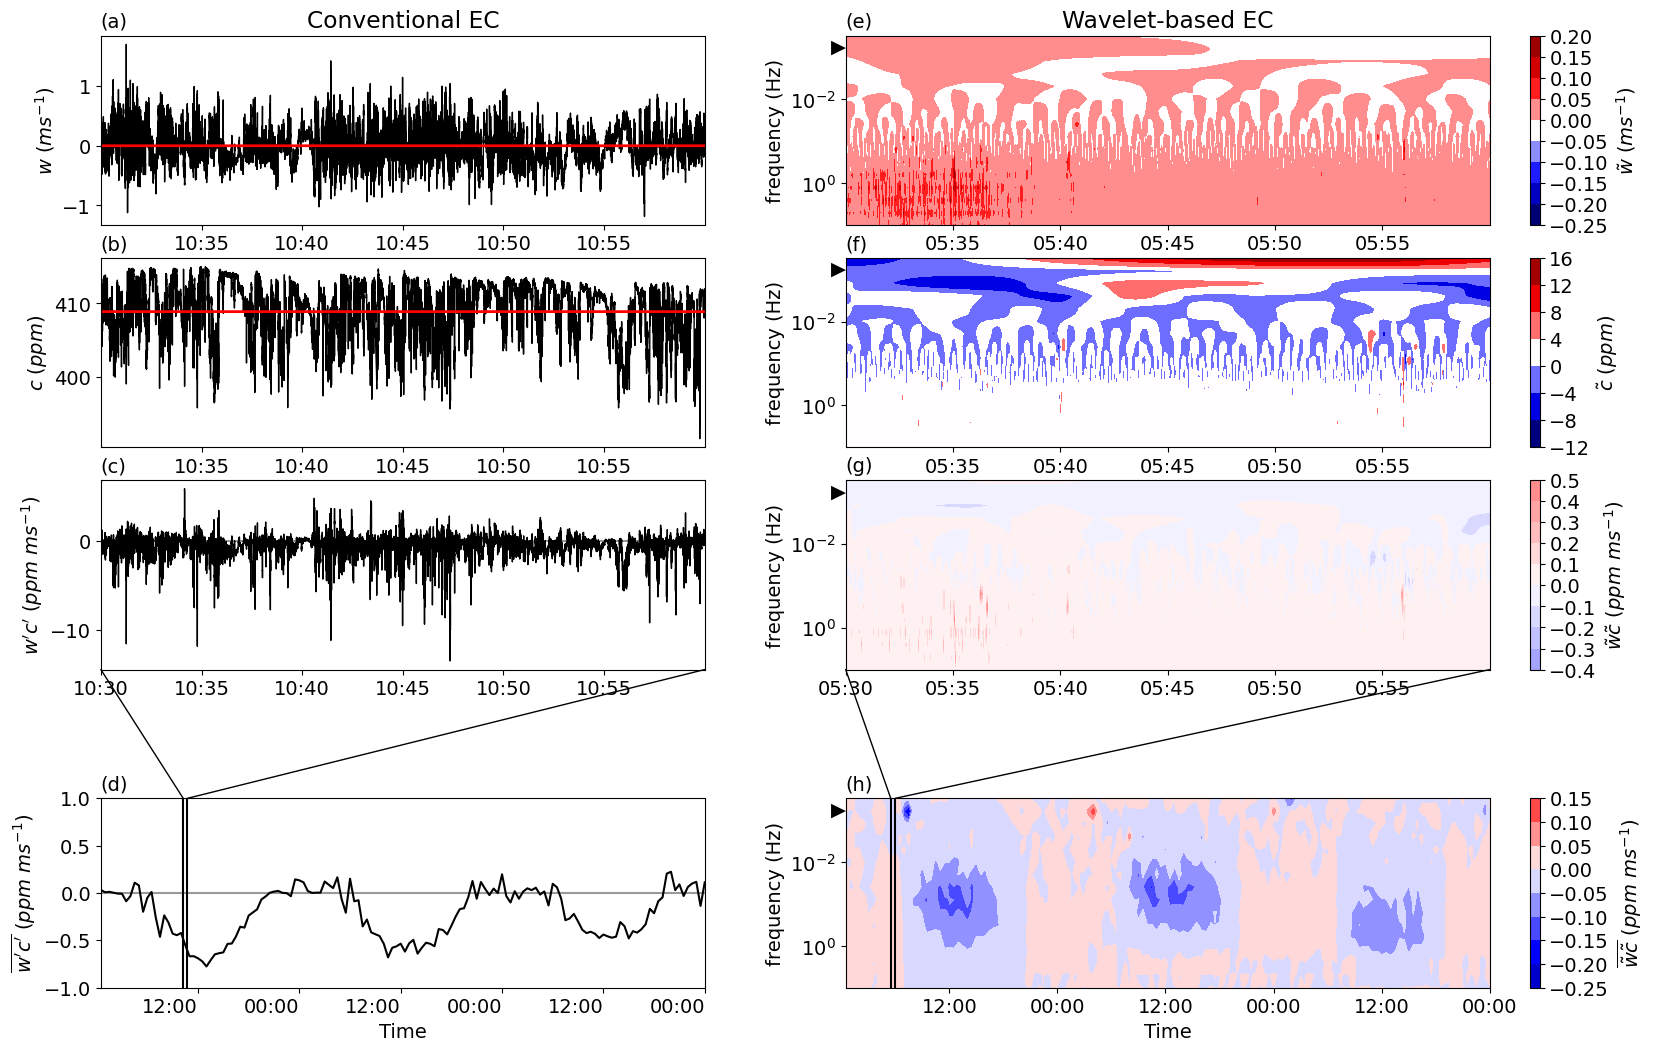

In [15]:
plt.rcParams.update({'font.size': 14})

fullraw_data = common_data.copy()
fs = [1/j2sj(j_, 20) for j_ in wl_data.sj]
f30 = len([j_ for j_ in wl_data.sj if j_ < 14.13575])
Xi, Yi = np.meshgrid(fullraw_data.TIMESTAMP_ns.values, fs)

fullraw_data['wl_w'] = np.nansum(wl_data.w, 0)
fullraw_data['wl_co2'] = np.nansum(wl_data.co2, 0)
fullraw_data['wl_w_'] = np.nansum(wl_data.w[f30:], 0)
fullraw_data['wl_co2_'] = np.nansum(wl_data.co2[f30:], 0)
fullraw_data['wl_wco2'] = np.nansum(
    (wl_data.w * wl_data.co2)[:f30], 0)

thisraw_data = fullraw_data.copy()
thisdate = "2022-05-13 10:30:00"
thisdate = pd.to_datetime(thisdate)
thisraw_data = thisraw_data.query(f'TIMESTAMP == "{thisdate}"')
# thisraw_data = thisraw_data[16000 : 20000]
thisraw_data = thisraw_data.reset_index(drop=True)
thisraw_data.index += 16000

plt.subplots(5, 2, figsize=(20, 14), gridspec_kw={
             'height_ratios': [3, 3, 3, 1, 3],
             'width_ratios': [3, 4]})

plt.subplot(521)
plt.title('Conventional EC')
plt.title(f'({string.ascii_lowercase[0]})', loc='left', size=14)
plt.plot(thisraw_data['TIMESTAMP_ns'], thisraw_data['w'],
         label='observed', c='k', lw=1)
plt.plot(thisraw_data['TIMESTAMP_ns'], thisraw_data['w_'],
         label='mean', c='red', ls='-', lw=2)
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.xlim(min(thisraw_data['TIMESTAMP_ns']), max(thisraw_data['TIMESTAMP_ns']))
plt.xticks(plt.gca().get_xticks()[1:])
plt.ylabel(r'$w$ ($ms^{-1}$)')

plt.subplot(523)
plt.title(f'({string.ascii_lowercase[1]})', loc='left', size=14)
plt.plot(thisraw_data['TIMESTAMP_ns'], thisraw_data['co2'],
         label='observed', c='k', lw=1)
plt.plot(thisraw_data['TIMESTAMP_ns'], thisraw_data['co2_'],
         label='mean', c='red', ls='-', lw=2)
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.xlim(min(thisraw_data['TIMESTAMP_ns']), max(thisraw_data['TIMESTAMP_ns']))
plt.xticks(plt.gca().get_xticks()[1:])
plt.ylabel(r'$c$ ($ppm$)')

plt.subplot(525)
plt.title(f'({string.ascii_lowercase[2]})', loc='left', size=14)
plt.axhline(0, c='.60')
plt.plot(thisraw_data['TIMESTAMP_ns'],
         (thisraw_data['w'] - thisraw_data['w_']) *
         (thisraw_data['co2'] - thisraw_data['co2_']), c='k', lw=1)
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.xlim(min(thisraw_data['TIMESTAMP_ns']), max(thisraw_data['TIMESTAMP_ns']))
plt.ylabel(r"$w'c'$ ($ppm\ ms^{-1}$)")
#plt.xlabel('Data points')
lastax = plt.gca()

plt.subplot(527)
plt.gca().axis('off')

plt.subplot(529)
plt.title(f'({string.ascii_lowercase[3]})', loc='left', size=14)
plt.axhline(0, c='.60')
plt.axvline(thisdate - pd.Timedelta('15min'), c='k')
plt.axvline(thisdate + pd.Timedelta('15min'), c='k')
# assuming density of dry air ~ 42 mol/m3
fullraw_data.groupby('TIMESTAMP').apply(lambda row: pd.Series({'covariance': np.cov(row['w'], row['co2'])[0][1]})).reset_index(drop=False).plot(
    x='TIMESTAMP', ax=plt.gca(), c='k')
plt.ylabel(r"$\overline{w'c'}$ ($ppm\ ms^{-1}$)")
plt.legend().remove()
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))  # \n%d/%m'))
plt.xticks(rotation=0)
plt.xlabel('Time')
plt.xlim(min(fullraw_data['TIMESTAMP']), max(fullraw_data['TIMESTAMP']))
plt.ylim(-1, 1)

con = ConnectionPatch(xyA=(thisdate - pd.Timedelta('15min'), plt.gca().get_ylim()[1]), xyB=(0, 0), coordsA="data", coordsB="axes fraction",
                      axesA=plt.gca(), axesB=lastax, color="k")
plt.gca().add_artist(con)
con = ConnectionPatch(xyA=(thisdate + pd.Timedelta('15min'), plt.gca().get_ylim()[1]), xyB=(1, 0), coordsA="data", coordsB="axes fraction",
                      axesA=plt.gca(), axesB=lastax, color="k")
plt.gca().add_artist(con)

##############################################################################################################

i0 = 10#10.2
i1 = 11#10.8

plt.subplot(522)
plt.title('Wavelet-based EC')
plt.title(f'({string.ascii_lowercase[4]})', loc='left', size=14)
plt.annotate('▶', xy=(min(Xi[0, int(i0*36000):int(i1*36000)]), 1/(60*60*.5)), 
             ha='right', va='center', annotation_clip=False)
# plt.axhline(1/(60*60*.5), c='k')
plt.contourf(Xi[:-1, int(i0*36000):int(i1*36000)], 
             Yi[:-1, int(i0*36000):int(i1*36000)], 
             wl_data.w[:-1, int(i0*36000):int(i1*36000)], 
             cmap=plt.cm.seismic)
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.xticks(plt.gca().get_xticks()[1:])
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('frequency (Hz)')
plt.colorbar().set_label(r"$\~w$ ($ms^{-1}$)", rotation=90)

plt.subplot(524)
plt.title(f'({string.ascii_lowercase[5]})', loc='left', size=14)
# plt.axhline(1/(60*60*.5), c='k')
plt.annotate('▶', xy=(min(Xi[0, int(i0*36000):int(i1*36000)]), 1/(60*60*.5)),
             ha='right', va='center', annotation_clip=False)
plt.contourf(Xi[:-1, int(i0*36000):int(i1*36000)], Yi[:-1, int(i0*36000)
             :int(i1*36000)], wl_data.co2[:-1, int(i0*36000):int(i1*36000)], cmap=plt.cm.seismic)
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.xticks(plt.gca().get_xticks()[1:])
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('frequency (Hz)')
plt.colorbar().set_label(r"$\~c$ ($ppm$)", rotation=90)

plt.subplot(526)
plt.title(f'({string.ascii_lowercase[6]})', loc='left', size=14)
Zi = (wl_data.w * wl_data.co2)
# plt.axhline(1/(60*60*.5), c='k')
plt.annotate('▶', xy=(min(Xi[0, int(i0*36000):int(i1*36000)]), 1/(60*60*.5)),
             ha='right', va='center', annotation_clip=False)
plt.contourf(Xi[:-1, int(i0*36000):int(i1*36000)], Yi[:-1, int(i0*36000):int(i1*36000)], Zi[:-1, int(i0*36000):int(i1*36000)],
             vmin=-2, vmax=2, cmap=plt.cm.seismic)
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('frequency (Hz)')
plt.colorbar().set_label(r"$\~w\~c$ ($ppm\ ms^{-1}$)")
lastax = plt.gca()

plt.subplot(528)
plt.gca().axis('off')

plt.subplot(5, 2, 10)
plt.title(f'({string.ascii_lowercase[7]})', loc='left', size=14)
Zj = pd.concat([fullraw_data['TIMESTAMP'], pd.DataFrame(
    (wl_data.w * wl_data.co2).T)], axis=1).groupby('TIMESTAMP').agg(np.nanmean).values.T
Xj, Yj = np.meshgrid(fullraw_data.TIMESTAMP.unique(), fs)

plt.annotate('▶', xy=(min(Xi[0]), 1/(60*60*.5)), 
             ha='right', va='center', annotation_clip=False)
# plt.annotate('30 min', xy=(0.85, 0.85), xycoords='axes fraction')
# plt.axhline(1/(60*60*.5), c='k')
plt.axvline(min(Xi[0, int(i0*36000):int(i1*36000)]), c='k')
plt.axvline(max(Xi[0, int(i0*36000):int(i1*36000)]), c='k')
plt.contourf(Xj[:-1], Yj[:-1], Zj[:-1], vmin=-np.quantile(abs(Zi[:-1]), .99),
             vmax=np.quantile(abs(Zi[:-1]), .99), cmap=plt.cm.seismic)
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M')) #\n%d/%m'))
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('frequency (Hz)')
plt.xlabel('Time')
plt.colorbar().set_label(r"$\overline{\~w\~c}$ ($ppm\ ms^{-1}$)")
"""
plt.plot(thisraw_data.TIMESTAMP.unique(), np.nansum(Zj[:15], 0), c='k')
plt.xlim(min(thisraw_data.TIMESTAMP.unique()), max(thisraw_data.TIMESTAMP.unique()))
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M\n%d/%m'))
plt.xlabel('Date and time')
"""
con = ConnectionPatch(xyA=(min(Xi[0, int(i0*36000):int(i1*36000)]), plt.gca().get_ylim()[1]), xyB=(0, 0), coordsA="data", coordsB="axes fraction",
                      axesA=plt.gca(), axesB=lastax, color="k")
plt.gca().add_artist(con)
con = ConnectionPatch(xyA=(max(Xi[0, int(i0*36000):int(i1*36000)]), plt.gca().get_ylim()[1]), xyB=(1, 0), coordsA="data", coordsB="axes fraction",
                      axesA=plt.gca(), axesB=lastax, color="k")
plt.gca().add_artist(con)

plt.show()

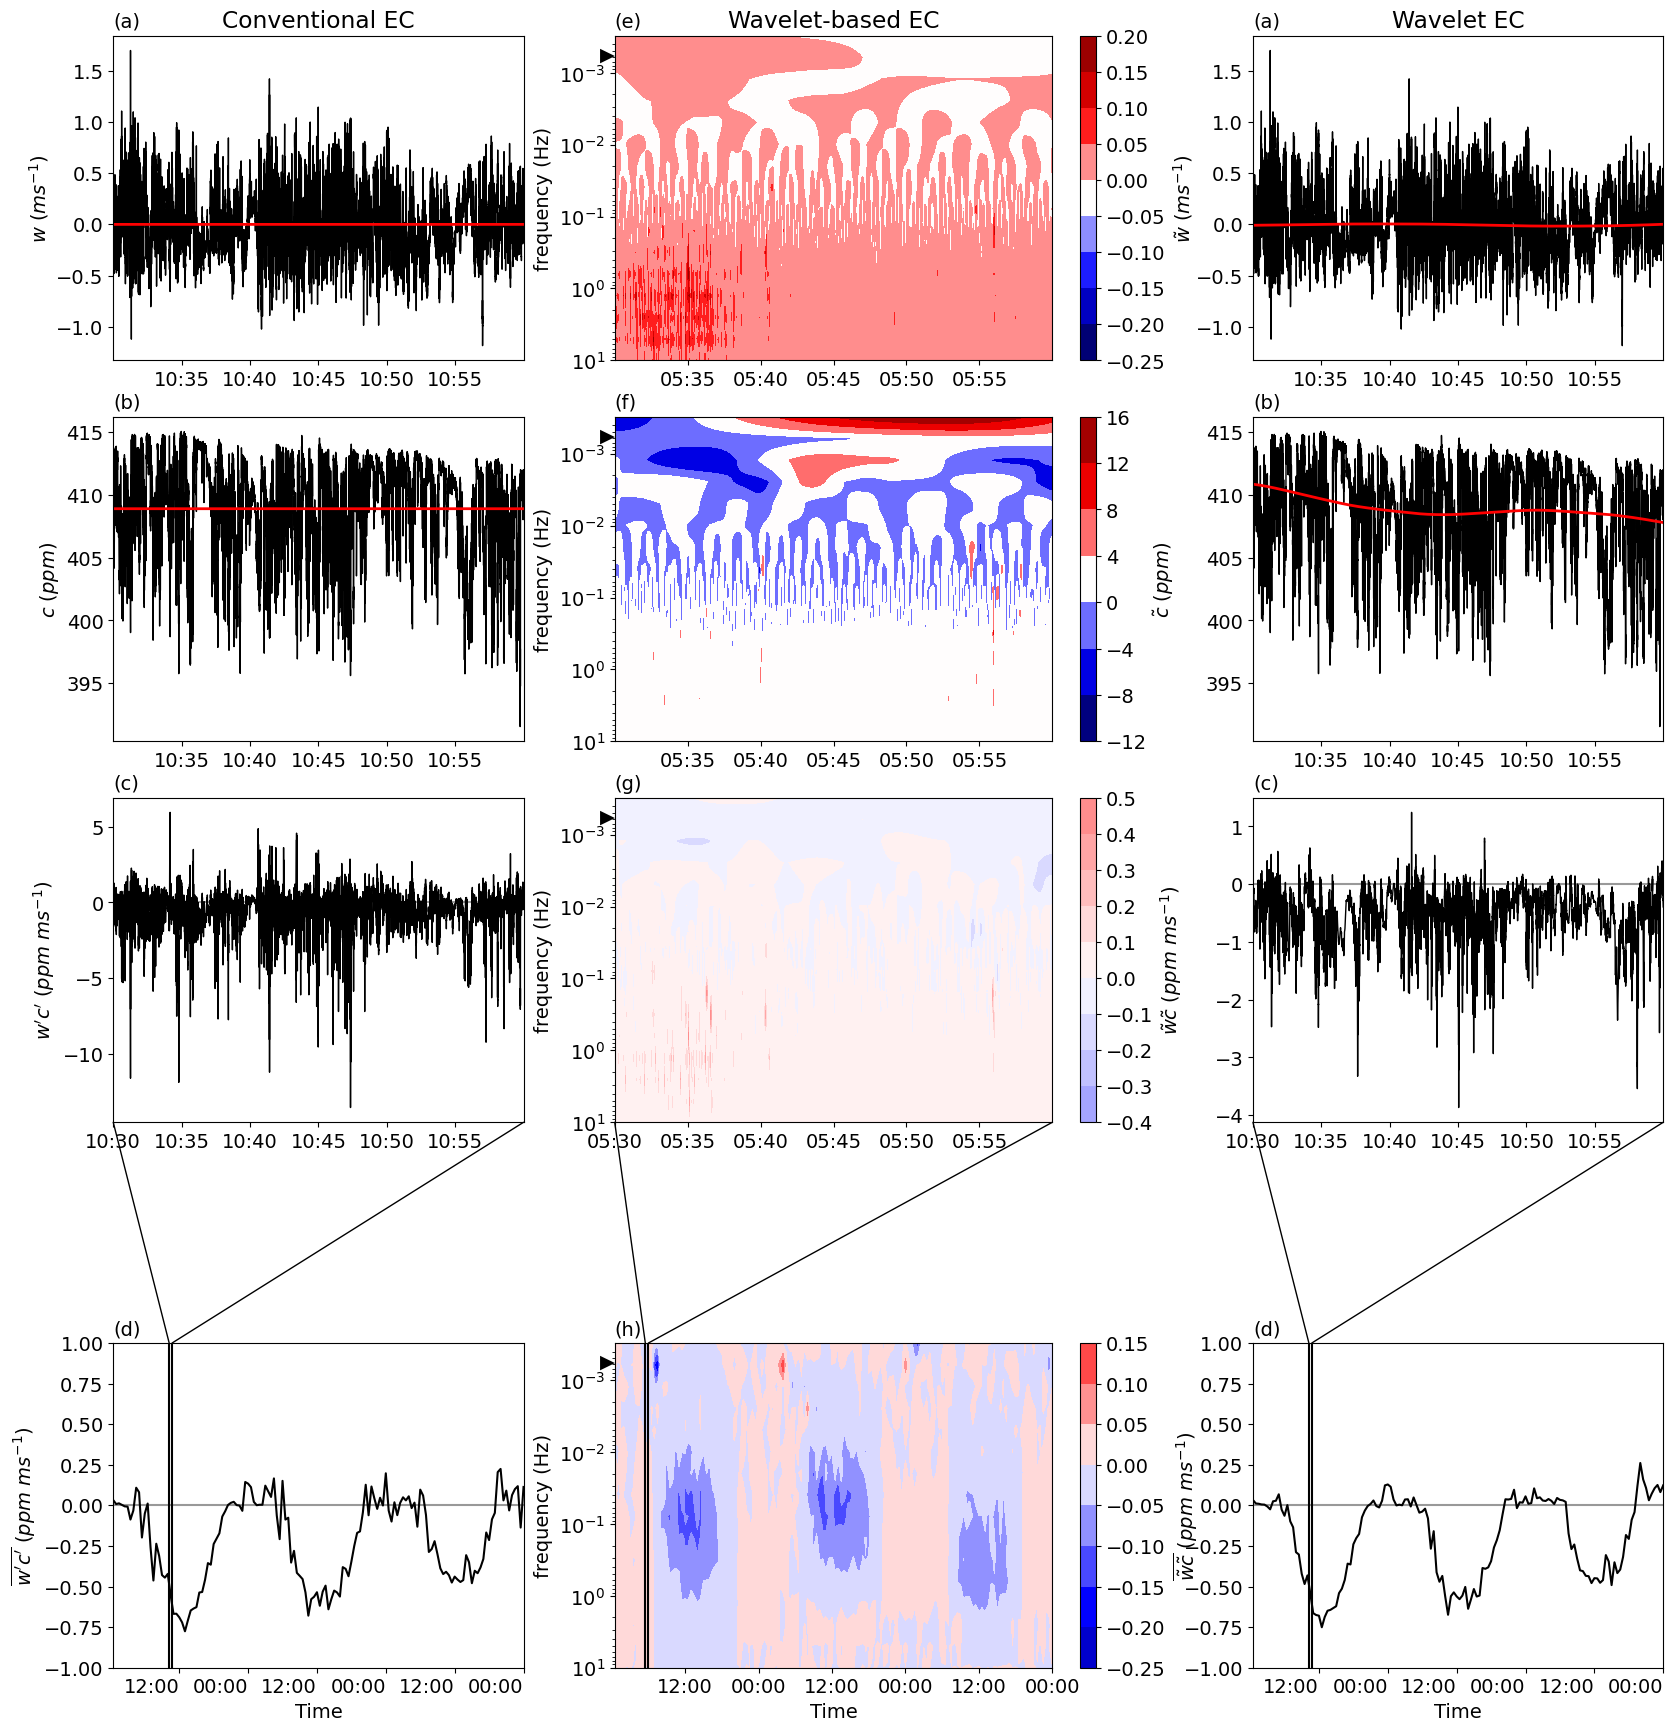

In [16]:
plt.rcParams.update({'font.size': 14})

fullraw_data = fullraw_data.copy()
fs = [1/j2sj(j_, 20) for j_ in wl_data.sj]
f30 = len([j_ for j_ in wl_data.sj if j_ < 14.13575])
Xi, Yi = np.meshgrid(fullraw_data.TIMESTAMP_ns.values, fs)

fullraw_data['wl_w'] = np.nansum(wl_data.w, 0)
fullraw_data['wl_co2'] = np.nansum(wl_data.co2, 0)
fullraw_data['wl_w_'] = np.nansum(wl_data.w[f30:], 0)
fullraw_data['wl_co2_'] = np.nansum(wl_data.co2[f30:], 0)
fullraw_data['wl_wco2'] = np.nansum(
    (wl_data.w * wl_data.co2)[:f30], 0)

thisraw_data = fullraw_data.copy()
thisdate = "2022-05-13 10:30:00"
thisdate = pd.to_datetime(thisdate)
thisraw_data = thisraw_data.query(f'TIMESTAMP == "{thisdate}"')
# thisraw_data = thisraw_data[16000 : 20000]
thisraw_data = thisraw_data.reset_index(drop=True)
thisraw_data.index += 16000

m = 5
n = 3
plt.subplots(m, n, figsize=(m*4, n*8), gridspec_kw={
             'height_ratios': [3, 3, 3, 1, 3],
             'width_ratios': [3, 4, 3]})

plt.subplot(m, n, n*0 + 1)
plt.title('Conventional EC')
plt.title(f'({string.ascii_lowercase[0]})', loc='left', size=14)
plt.plot(thisraw_data['TIMESTAMP_ns'], thisraw_data['w'],
         label='observed', c='k', lw=1)
plt.plot(thisraw_data['TIMESTAMP_ns'], thisraw_data['w_'],
         label='mean', c='red', ls='-', lw=2)
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.xlim(min(thisraw_data['TIMESTAMP_ns']), max(thisraw_data['TIMESTAMP_ns']))
plt.xticks(plt.gca().get_xticks()[1:])
plt.ylabel(r'$w$ ($ms^{-1}$)')

plt.subplot(m, n, n*1 + 1)
plt.title(f'({string.ascii_lowercase[1]})', loc='left', size=14)
plt.plot(thisraw_data['TIMESTAMP_ns'], thisraw_data['co2'],
         label='observed', c='k', lw=1)
plt.plot(thisraw_data['TIMESTAMP_ns'], thisraw_data['co2_'],
         label='mean', c='red', ls='-', lw=2)
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.xlim(min(thisraw_data['TIMESTAMP_ns']), max(thisraw_data['TIMESTAMP_ns']))
plt.xticks(plt.gca().get_xticks()[1:])
plt.ylabel(r'$c$ ($ppm$)')

plt.subplot(m, n, n*2 + 1)
plt.title(f'({string.ascii_lowercase[2]})', loc='left', size=14)
plt.axhline(0, c='.60')
plt.plot(thisraw_data['TIMESTAMP_ns'],
         (thisraw_data['w'] - thisraw_data['w_']) *
         (thisraw_data['co2'] - thisraw_data['co2_']), c='k', lw=1)
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.xlim(min(thisraw_data['TIMESTAMP_ns']), max(thisraw_data['TIMESTAMP_ns']))
plt.ylabel(r"$w'c'$ ($ppm\ ms^{-1}$)")
# plt.xlabel('Data points')
lastax = plt.gca()

plt.subplot(m, n, n*3 + 1)
plt.gca().axis('off')

plt.subplot(m, n, n*4 + 1)
plt.title(f'({string.ascii_lowercase[3]})', loc='left', size=14)
plt.axhline(0, c='.60')
plt.axvline(thisdate - pd.Timedelta('15min'), c='k')
plt.axvline(thisdate + pd.Timedelta('15min'), c='k')
# assuming density of dry air ~ 42 mol/m3
fullraw_data.groupby('TIMESTAMP').apply(lambda row: pd.Series({'covariance': np.cov(row['w'], row['co2'])[0][1]})).reset_index(drop=False).plot(
    x='TIMESTAMP', ax=plt.gca(), c='k')
plt.ylabel(r"$\overline{w'c'}$ ($ppm\ ms^{-1}$)")
plt.legend().remove()
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))  # \n%d/%m'))
plt.xticks(rotation=0)
plt.xlabel('Time')
plt.xlim(min(fullraw_data['TIMESTAMP']), max(fullraw_data['TIMESTAMP']))
plt.ylim(-1, 1)

con = ConnectionPatch(xyA=(thisdate - pd.Timedelta('15min'), plt.gca().get_ylim()[1]), xyB=(0, 0), coordsA="data", coordsB="axes fraction",
                      axesA=plt.gca(), axesB=lastax, color="k")
plt.gca().add_artist(con)
con = ConnectionPatch(xyA=(thisdate + pd.Timedelta('15min'), plt.gca().get_ylim()[1]), xyB=(1, 0), coordsA="data", coordsB="axes fraction",
                      axesA=plt.gca(), axesB=lastax, color="k")
plt.gca().add_artist(con)

##############################################################################################################

i0 = 10  # 10.2
i1 = 11  # 10.8

plt.subplot(m, n, n*0 + 2)
plt.title('Wavelet-based EC')
plt.title(f'({string.ascii_lowercase[4]})', loc='left', size=14)
plt.annotate('▶', xy=(min(Xi[0, int(i0*36000):int(i1*36000)]), 1/(60*60*.5)),
             ha='right', va='center', annotation_clip=False)
# plt.axhline(1/(60*60*.5), c='k')
plt.contourf(Xi[:-1, int(i0*36000):int(i1*36000)],
             Yi[:-1, int(i0*36000):int(i1*36000)],
             wl_data.w[:-1, int(i0*36000):int(i1*36000)],
             cmap=plt.cm.seismic)
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.xticks(plt.gca().get_xticks()[1:])
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('frequency (Hz)')
plt.colorbar().set_label(r"$\~w$ ($ms^{-1}$)", rotation=90)

plt.subplot(m, n, n*1 + 2)
plt.title(f'({string.ascii_lowercase[5]})', loc='left', size=14)
# plt.axhline(1/(60*60*.5), c='k')
plt.annotate('▶', xy=(min(Xi[0, int(i0*36000):int(i1*36000)]), 1/(60*60*.5)),
             ha='right', va='center', annotation_clip=False)
plt.contourf(Xi[:-1, int(i0*36000):int(i1*36000)], Yi[:-1, int(i0*36000):int(i1*36000)],
             wl_data.co2[:-1, int(i0*36000):int(i1*36000)], cmap=plt.cm.seismic)
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.xticks(plt.gca().get_xticks()[1:])
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('frequency (Hz)')
plt.colorbar().set_label(r"$\~c$ ($ppm$)", rotation=90)

plt.subplot(m, n, n*2 + 2)
plt.title(f'({string.ascii_lowercase[6]})', loc='left', size=14)
Zi = (wl_data.w * wl_data.co2)
# plt.axhline(1/(60*60*.5), c='k')
plt.annotate('▶', xy=(min(Xi[0, int(i0*36000):int(i1*36000)]), 1/(60*60*.5)),
             ha='right', va='center', annotation_clip=False)
plt.contourf(Xi[:-1, int(i0*36000):int(i1*36000)], Yi[:-1, int(i0*36000):int(i1*36000)], Zi[:-1, int(i0*36000):int(i1*36000)],
             vmin=-2, vmax=2, cmap=plt.cm.seismic)
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('frequency (Hz)')
plt.colorbar().set_label(r"$\~w\~c$ ($ppm\ ms^{-1}$)")
lastax = plt.gca()

plt.subplot(m, n, n*3 + 2)
plt.gca().axis('off')

plt.subplot(m, n, n*4 + 2)
plt.title(f'({string.ascii_lowercase[7]})', loc='left', size=14)
Zj = pd.concat([fullraw_data['TIMESTAMP'], pd.DataFrame(
    (wl_data.w * wl_data.co2).T)], axis=1).groupby('TIMESTAMP').agg(np.nanmean).values.T
Xj, Yj = np.meshgrid(fullraw_data.TIMESTAMP.unique(), fs)

plt.annotate('▶', xy=(min(Xi[0]), 1/(60*60*.5)),
             ha='right', va='center', annotation_clip=False)
# plt.annotate('30 min', xy=(0.85, 0.85), xycoords='axes fraction')
# plt.axhline(1/(60*60*.5), c='k')
plt.axvline(min(Xi[0, int(i0*36000):int(i1*36000)]), c='k')
plt.axvline(max(Xi[0, int(i0*36000):int(i1*36000)]), c='k')
plt.contourf(Xj[:-1], Yj[:-1], Zj[:-1], vmin=-np.quantile(abs(Zi[:-1]), .99),
             vmax=np.quantile(abs(Zi[:-1]), .99), cmap=plt.cm.seismic)
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))  # \n%d/%m'))
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('frequency (Hz)')
plt.xlabel('Time')
plt.colorbar().set_label(r"$\overline{\~w\~c}$ ($ppm\ ms^{-1}$)")
"""
plt.plot(thisraw_data.TIMESTAMP.unique(), np.nansum(Zj[:15], 0), c='k')
plt.xlim(min(thisraw_data.TIMESTAMP.unique()), max(thisraw_data.TIMESTAMP.unique()))
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M\n%d/%m'))
plt.xlabel('Date and time')
"""
con = ConnectionPatch(xyA=(min(Xi[0, int(i0*36000):int(i1*36000)]), plt.gca().get_ylim()[1]), xyB=(0, 0), coordsA="data", coordsB="axes fraction",
                      axesA=plt.gca(), axesB=lastax, color="k")
plt.gca().add_artist(con)
con = ConnectionPatch(xyA=(max(Xi[0, int(i0*36000):int(i1*36000)]), plt.gca().get_ylim()[1]), xyB=(1, 0), coordsA="data", coordsB="axes fraction",
                      axesA=plt.gca(), axesB=lastax, color="k")
plt.gca().add_artist(con)


##############################################################################################################

plt.subplot(m, n, n*0 + 3)
plt.title('Wavelet EC')
plt.title(f'({string.ascii_lowercase[0]})', loc='left', size=14)
plt.plot(thisraw_data['TIMESTAMP_ns'], thisraw_data['wl_w'],
         label='observed', c='k', lw=1)
plt.plot(thisraw_data['TIMESTAMP_ns'], thisraw_data['wl_w_'],
         label='mean', c='red', ls='-', lw=2)
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.xlim(min(thisraw_data['TIMESTAMP_ns']), max(thisraw_data['TIMESTAMP_ns']))
plt.xticks(plt.gca().get_xticks()[1:])
# plt.ylabel(r'$w$ ($ms^{-1}$)')
plt.ylabel('')

plt.subplot(m, n, n*1 + 3)
plt.title(f'({string.ascii_lowercase[1]})', loc='left', size=14)
plt.plot(thisraw_data['TIMESTAMP_ns'], thisraw_data['wl_co2'],
         label='observed', c='k', lw=1)
plt.plot(thisraw_data['TIMESTAMP_ns'], thisraw_data['wl_co2_'],
         label='mean', c='red', ls='-', lw=2)
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.xlim(min(thisraw_data['TIMESTAMP_ns']), max(thisraw_data['TIMESTAMP_ns']))
plt.xticks(plt.gca().get_xticks()[1:])
# plt.ylabel(r'$c$ ($ppm$)')
plt.ylabel('')

plt.subplot(m, n, n*2 + 3)
plt.title(f'({string.ascii_lowercase[2]})', loc='left', size=14)
plt.axhline(0, c='.60')
plt.plot(thisraw_data['TIMESTAMP_ns'],
         thisraw_data['wl_wco2'], c='k', lw=1)
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.xlim(min(thisraw_data['TIMESTAMP_ns']), max(thisraw_data['TIMESTAMP_ns']))
# plt.ylabel(r"$w'c'$ ($ppm\ ms^{-1}$)")
plt.ylabel('')
# plt.xlabel('Data points')
lastax = plt.gca()

plt.subplot(m, n, n*3 + 3)
plt.gca().axis('off')

plt.subplot(m, n, n*4 + 3)
plt.title(f'({string.ascii_lowercase[3]})', loc='left', size=14)
plt.axhline(0, c='.60')
plt.axvline(thisdate - pd.Timedelta('15min'), c='k')
plt.axvline(thisdate + pd.Timedelta('15min'), c='k')
# assuming density of dry air ~ 42 mol/m3
fullraw_data.groupby('TIMESTAMP')['wl_wco2'].mean().reset_index(drop=False).plot(
    x='TIMESTAMP', ax=plt.gca(), c='k')
plt.ylabel(r"$\overline{w'c'}$ ($ppm\ ms^{-1}$)")
plt.legend().remove()
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))  # \n%d/%m'))
plt.xticks(rotation=0)
plt.xlabel('Time')
plt.xlim(min(fullraw_data['TIMESTAMP']), max(fullraw_data['TIMESTAMP']))
plt.ylabel('')
plt.ylim(-1, 1)

con = ConnectionPatch(xyA=(thisdate - pd.Timedelta('15min'), plt.gca().get_ylim()[1]), xyB=(0, 0), coordsA="data", coordsB="axes fraction",
                      axesA=plt.gca(), axesB=lastax, color="k")
plt.gca().add_artist(con)
con = ConnectionPatch(xyA=(thisdate + pd.Timedelta('15min'), plt.gca().get_ylim()[1]), xyB=(1, 0), coordsA="data", coordsB="axes fraction",
                      axesA=plt.gca(), axesB=lastax, color="k")
plt.gca().add_artist(con)

plt.show()

20Hz to 30min *(in time)*

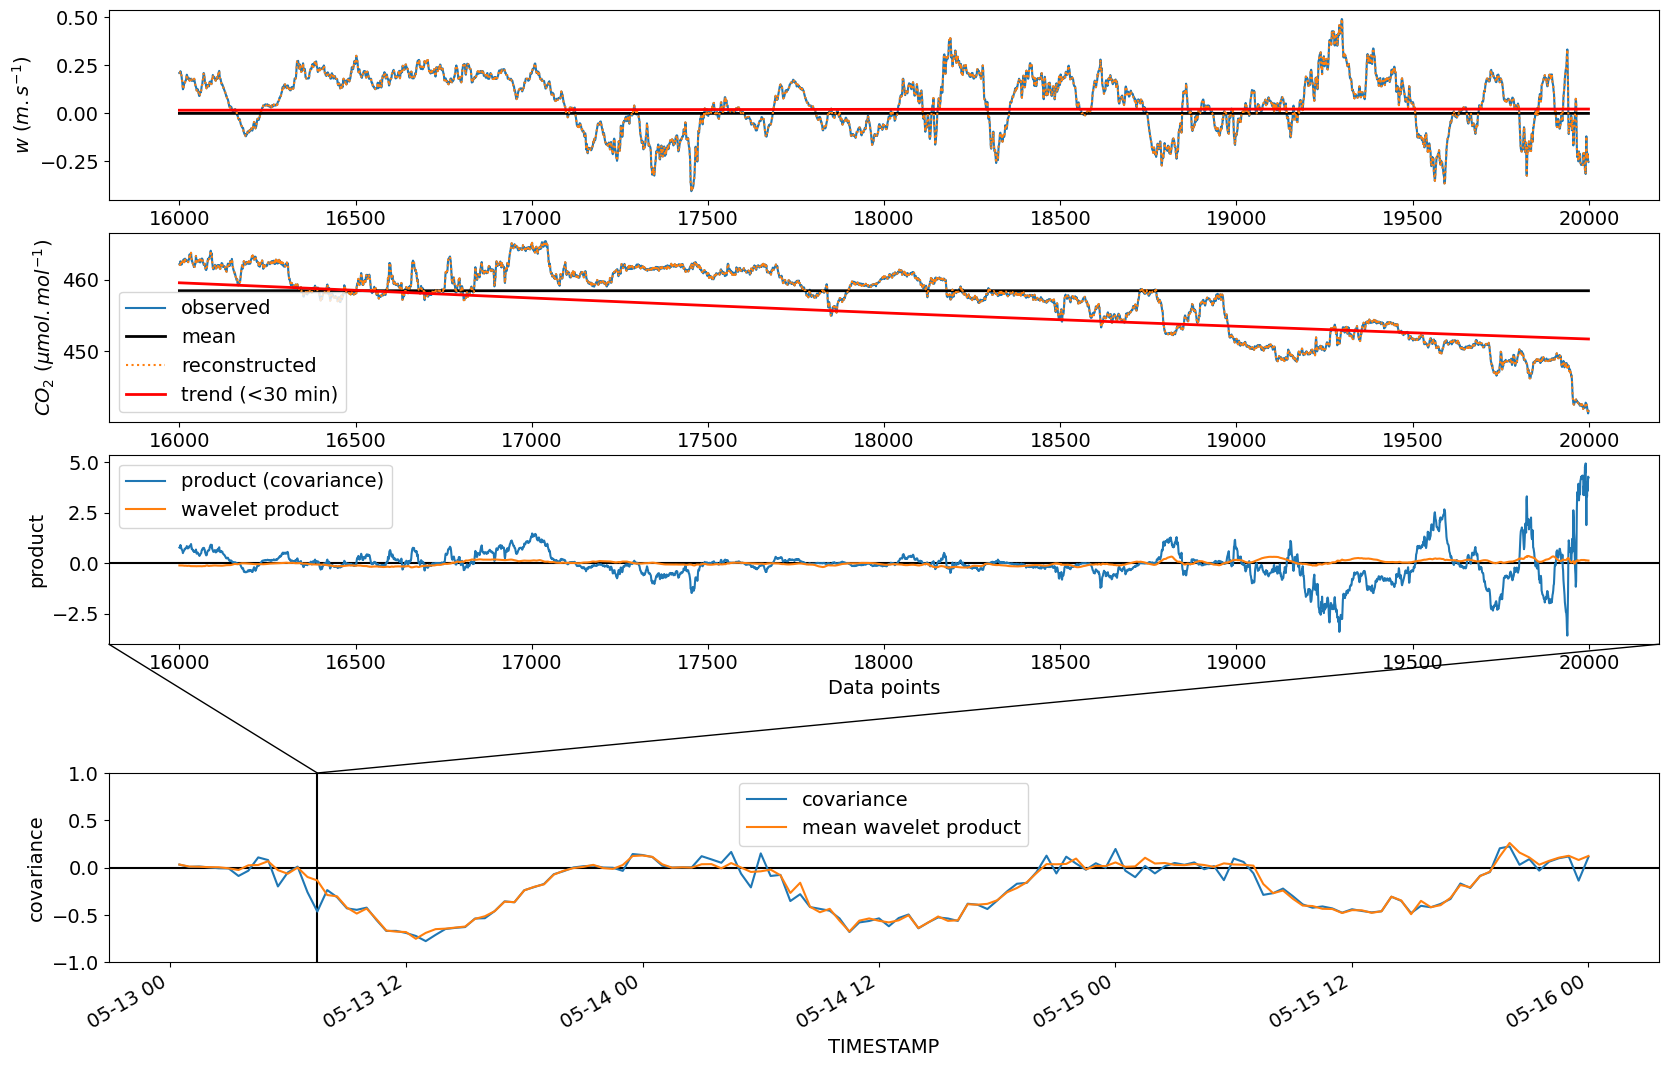

In [17]:
plt.rcParams.update({'font.size': 14})

fullraw_data = wl_data.data.copy()
fs = [1/j2sj(j_, 20) for j_ in wl_data.sj]
f30 = len([j_ for j_ in wl_data.sj if j_ < 14.13575])

fullraw_data['wl_w'] = np.nansum(wl_data.w, 0)
fullraw_data['wl_co2'] = np.nansum(wl_data.co2, 0)
fullraw_data['wl_w_'] = np.nansum(wl_data.w[f30:], 0)
fullraw_data['wl_co2_'] = np.nansum(wl_data.co2[f30:], 0)
fullraw_data['wl_wco2'] = np.nansum(
    (wl_data.w * wl_data.co2)[:f30], 0)

thisraw_data = fullraw_data.copy()
thisdate = "2022-05-13 07:30:00"
thisdate = pd.to_datetime(thisdate)
thisraw_data = thisraw_data.query(f'TIMESTAMP == "{thisdate}"')
thisraw_data = thisraw_data[16000 : 20000]
thisraw_data = thisraw_data.reset_index(drop=True)
thisraw_data.index += 16000

plt.subplots(5,1, figsize=(20,14), gridspec_kw={'height_ratios': [3,3,3,1,3]})

plt.subplot(511)
plt.plot(thisraw_data['w'], label='observed')
plt.plot(thisraw_data['w_'], label='mean', c='k', ls='-', lw=2)
plt.plot(thisraw_data['wl_w'], label='reconstructed', ls=':')
plt.plot(thisraw_data['wl_w_'], label='trend (<30 min)', c='r', ls='-', lw=2)
plt.ylabel(r'$w$ ($m.s^{-1}$)')

plt.subplot(512)
plt.plot(thisraw_data['co2'], label='observed')
plt.plot(thisraw_data['co2_'], label='mean', c='k', ls='-', lw=2)
plt.plot(thisraw_data['wl_co2'], label='reconstructed', ls=':')
plt.plot(thisraw_data['wl_co2_'], label='trend (<30 min)', c='r', ls='-', lw=2)
plt.ylabel(r'$CO_2$ ($μmol.mol^{-1}$)')
plt.legend()

plt.subplot(513)
plt.axhline(0, c='k')
plt.plot((thisraw_data['w'] - thisraw_data['w_']) *
         (thisraw_data['co2'] - thisraw_data['co2_']), label='product (covariance)')
plt.plot(thisraw_data['wl_wco2'], label='wavelet product')
plt.ylabel('product')
plt.xlabel('Data points')
plt.xlabel('Data points')
plt.legend()
lastax = plt.gca()

plt.subplot(514)
plt.gca().axis('off')

plt.subplot(515)
plt.axhline(0, c='k')
plt.axvline(thisdate, c='k')
# assuming density of dry air ~ 42 mol/m3 
fullraw_data.groupby('TIMESTAMP').apply(lambda row: pd.Series({'covariance': np.cov(row['w'], row['co2'])[0][1]})).reset_index(drop=False).plot(
    x='TIMESTAMP', ax=plt.gca(), label='covariance')
fullraw_data.groupby('TIMESTAMP')['wl_wco2'].agg(np.nanmean).reset_index(drop=False).rename(columns={'wl_wco2': 'mean wavelet product'}).plot(
    x='TIMESTAMP', ax=plt.gca())
plt.ylabel('covariance')
plt.legend()
plt.ylim(-1, 1)

from matplotlib.patches import ConnectionPatch
con = ConnectionPatch(xyA=(thisdate,plt.gca().get_ylim()[1]), xyB=(0,0), coordsA="data", coordsB="axes fraction",
                      axesA=plt.gca(), axesB=lastax, color="k")
plt.gca().add_artist(con)
con = ConnectionPatch(xyA=(thisdate,plt.gca().get_ylim()[1]), xyB=(1,0), coordsA="data", coordsB="axes fraction",
                      axesA=plt.gca(), axesB=lastax, color="k")
plt.gca().add_artist(con)

plt.show()

Noise

In [18]:
plt.rcParams.update({'font.size': 14})

fullraw_data = wl_data.data.copy()
# thisdate = "2022-05-13 15:30:00"
# thisdate = pd.to_datetime(thisdate)
# fullraw_data = fullraw_data.query(
#     f'TIMESTAMP == "{thisdate}"')
fullraw_data = fullraw_data.reset_index(drop=True)
# wl_data.data = corrraw_data.interpolate().dropna(axis=1, how='all').dropna()

# Add noise
fullraw_data['co2d'] = fullraw_data['co2'] - \
    fullraw_data.groupby('TIMESTAMP')['co2'].transform(np.nanmean)
noise_var = fullraw_data.groupby('TIMESTAMP')['co2d'].transform(np.var)
fullraw_data['co2_10'] = fullraw_data['co2'] + np.random.normal(
    0, np.sqrt(0.1 * noise_var), fullraw_data.shape[0])
fullraw_data['co2_5'] = fullraw_data['co2'] + np.random.normal(
    0, np.sqrt(0.2 * noise_var), fullraw_data.shape[0])
fullraw_data['co2_2'] = fullraw_data['co2'] + np.random.normal(
    0, np.sqrt(0.4 * noise_var), fullraw_data.shape[0])
fullraw_data['co2_1'] = fullraw_data['co2'] + np.random.normal(
    0, np.sqrt(0.9 * noise_var), fullraw_data.shape[0])


wl_signalw = wEC.wavelet_transform(fullraw_data['w'].to_list(), 'dwt', wavelet='db6', fs=20, f0=1/(.5*60*60), f1=10, fn=180,
                                               dj=1/12)
wl_signalc = wEC.wavelet_transform(fullraw_data['co2'].to_list(), 'dwt', wavelet='db6', fs=20, f0=1/(.5*60*60), f1=10, fn=180,
                                              dj=1/12)
wl_signalc10 = wEC.wavelet_transform(fullraw_data['co2_10'].to_list(), 'dwt', wavelet='db6', fs=20, f0=1/(.5*60*60), f1=10, fn=180,
                                              dj=1/12)
wl_signalc5 = wEC.wavelet_transform(fullraw_data['co2_5'].to_list(), 'dwt', wavelet='db6', fs=20, f0=1/(.5*60*60), f1=10, fn=180,
                                             dj=1/12)
wl_signalc2 = wEC.wavelet_transform(fullraw_data['co2_2'].to_list(), 'dwt', wavelet='db6', fs=20, f0=1/(.5*60*60), f1=10, fn=180,
                                             dj=1/12)
wl_signalc1 = wEC.wavelet_transform(fullraw_data['co2_1'].to_list(), 'dwt', wavelet='db6', fs=20, f0=1/(.5*60*60), f1=10, fn=180,
                                             dj=1/12)
j = wl_signalw.sj
wl_signalw = wl_signalw.wave
fs = [1/j2sj(j_, 20) for j_ in j]
f30 = len([j_ for j_ in j if j_ < 14.13575])

fullraw_data['wl_w'] = np.nansum(wl_signalw, 0)
fullraw_data['wl_co2'] = np.nansum(wl_signalc.wave, 0)
fullraw_data['wl_w_'] = np.nansum(wl_signalw[f30:], 0)

fullraw_data['wl_co2_'] = np.nansum(wl_signalc[f30:], 0)
fullraw_data['wl_co2_10'] = np.nansum(wl_signalc10[f30:], 0)
fullraw_data['wl_co2_5'] = np.nansum(wl_signalc5[f30:], 0)
fullraw_data['wl_co2_2'] = np.nansum(wl_signalc2[f30:], 0)
fullraw_data['wl_co2_1'] = np.nansum(wl_signalc1.wave[f30:], 0)
fullraw_data['wl_wco2'] = np.nansum((wl_signalw * wl_signalc)[:f30], 0)
fullraw_data['wl_wco2_10'] = np.nansum((wl_signalw * wl_signalc10.wave)[:f30], 0)
fullraw_data['wl_wco2_5'] = np.nansum((wl_signalw * wl_signalc5.wave)[:f30], 0)
fullraw_data['wl_wco2_2'] = np.nansum((wl_signalw * wl_signalc2.wave)[:f30], 0)
fullraw_data['wl_wco2_1'] = np.nansum((wl_signalw * wl_signalc1.wave)[:f30], 0)

wc = wl_signalw * wl_signalc.wave
fullraw_data['wl_wco2+'] = np.nansum(np.where(wc > 0, wc, 0)[:f30], 0)
fullraw_data['wl_wco2-'] = np.nansum(np.where(wc < 0, wc, 0)[:f30], 0)
wc = wl_signalw * wl_signalc10.wave
fullraw_data['wl_wco2+_10'] = np.nansum(np.where(wc > 0, wc, 0)[:f30], 0)
fullraw_data['wl_wco2-_10'] = np.nansum(np.where(wc < 0, wc, 0)[:f30], 0)
wc = wl_signalw * wl_signalc5.wave
fullraw_data['wl_wco2+_5'] = np.nansum(np.where(wc > 0, wc, 0)[:f30], 0)
fullraw_data['wl_wco2-_5'] = np.nansum(np.where(wc < 0, wc, 0)[:f30], 0)
wc = wl_signalw * wl_signalc2.wave
fullraw_data['wl_wco2+_2'] = np.nansum(np.where(wc > 0, wc, 0)[:f30], 0)
fullraw_data['wl_wco2-_2'] = np.nansum(np.where(wc < 0, wc, 0)[:f30], 0)
wc = wl_signalw * wl_signalc1.wave
fullraw_data['wl_wco2+_1'] = np.nansum(np.where(wc > 0, wc, 0)[:f30], 0)
fullraw_data['wl_wco2-_1'] = np.nansum(np.where(wc < 0, wc, 0)[:f30], 0)

thisraw_data = fullraw_data.copy()
thisdate = "2022-05-13 15:30:00"
thisdate = pd.to_datetime(thisdate)
thisraw_data = thisraw_data.query(f'TIMESTAMP == "{thisdate}"')
thisraw_data = thisraw_data[16000: 20000]
thisraw_data = thisraw_data.reset_index(drop=True)
thisraw_data.index += 16000

plt.subplots(1, 3, figsize=(12, 4))

plt.subplot(131)
plt.title('(a)', loc='left')
plt.title('covariance')
plt.axhline(0, c='k')

fullraw_data.groupby('TIMESTAMP')['wl_wco2'].agg(np.nanmean).reset_index(drop=False).rename(columns={'wl_wco2': 'original'}).plot(
    x='TIMESTAMP', ax=plt.gca(), c='r', zorder=9)
fullraw_data.groupby('TIMESTAMP')['wl_wco2_10'].agg(np.nanmean).reset_index(drop=False).rename(columns={'wl_wco2_10': '10:1'}).plot(
    x='TIMESTAMP', ax=plt.gca(), c='0.3')
fullraw_data.groupby('TIMESTAMP')['wl_wco2_5'].agg(np.nanmean).reset_index(drop=False).rename(columns={'wl_wco2_5': '5:1'}).plot(
    x='TIMESTAMP', ax=plt.gca(), c='0.4')
fullraw_data.groupby('TIMESTAMP')['wl_wco2_2'].agg(np.nanmean).reset_index(drop=False).rename(columns={'wl_wco2_2': '2.5:1'}).plot(
    x='TIMESTAMP', ax=plt.gca(), c='0.6')
fullraw_data.groupby('TIMESTAMP')['wl_wco2_1'].agg(np.nanmean).reset_index(drop=False).rename(columns={'wl_wco2_1': '1.1:1'}).plot(
    x='TIMESTAMP', ax=plt.gca(), c='0.8')
plt.ylabel(r'$\overline{wCO_2}$ ($ppm.m.s^{-1}$)')
plt.legend()
plt.xlabel('')

plt.subplot(132)
plt.title('(b)', loc='left')
plt.title('only positive')
plt.axhline(0, c='k')
fullraw_data.groupby('TIMESTAMP')['wl_wco2+'].agg(np.nanmean).reset_index(drop=False).rename(columns={'wl_wco2+': 'original'}).plot(
    x='TIMESTAMP', ax=plt.gca(), c='r', zorder=9)
fullraw_data.groupby('TIMESTAMP')['wl_wco2+_10'].agg(np.nanmean).reset_index(drop=False).rename(columns={'wl_wco2+_10': '10:1'}).plot(
    x='TIMESTAMP', ax=plt.gca(), c='0.3')
fullraw_data.groupby('TIMESTAMP')['wl_wco2+_5'].agg(np.nanmean).reset_index(drop=False).rename(columns={'wl_wco2+_5': '5:1'}).plot(
    x='TIMESTAMP', ax=plt.gca(), c='0.4')
fullraw_data.groupby('TIMESTAMP')['wl_wco2+_2'].agg(np.nanmean).reset_index(drop=False).rename(columns={'wl_wco2+_2': '2.5:1'}).plot(
    x='TIMESTAMP', ax=plt.gca(), c='0.6')
fullraw_data.groupby('TIMESTAMP')['wl_wco2+_1'].agg(np.nanmean).reset_index(drop=False).rename(columns={'wl_wco2+_1': '1.1:1'}).plot(
    x='TIMESTAMP', ax=plt.gca(), c='0.8')
plt.legend().remove()
plt.xlabel('')

plt.subplot(133)
plt.title('(c)', loc='left')
plt.title('only negative')
plt.axhline(0, c='k')
fullraw_data.groupby('TIMESTAMP')['wl_wco2-'].agg(np.nanmean).reset_index(drop=False).rename(columns={'wl_wco2-': 'original'}).plot(
    x='TIMESTAMP', ax=plt.gca(), c='r', zorder=9)
fullraw_data.groupby('TIMESTAMP')['wl_wco2-_10'].agg(np.nanmean).reset_index(drop=False).rename(columns={'wl_wco2-_10': '10:1'}).plot(
    x='TIMESTAMP', ax=plt.gca(), c='0.3')
fullraw_data.groupby('TIMESTAMP')['wl_wco2-_5'].agg(np.nanmean).reset_index(drop=False).rename(columns={'wl_wco2-_5': '5:1'}).plot(
    x='TIMESTAMP', ax=plt.gca(), c='0.4')
fullraw_data.groupby('TIMESTAMP')['wl_wco2-_2'].agg(np.nanmean).reset_index(drop=False).rename(columns={'wl_wco2-_2': '2.5:1'}).plot(
    x='TIMESTAMP', ax=plt.gca(), c='0.6')
fullraw_data.groupby('TIMESTAMP')['wl_wco2-_1'].agg(np.nanmean).reset_index(drop=False).rename(columns={'wl_wco2-_1': '1.1:1'}).plot(
    x='TIMESTAMP', ax=plt.gca(), c='0.8')
plt.legend().remove()
plt.xlabel('')

plt.show()

TypeError: type 'var_' is not subscriptable

Averaging and information lost

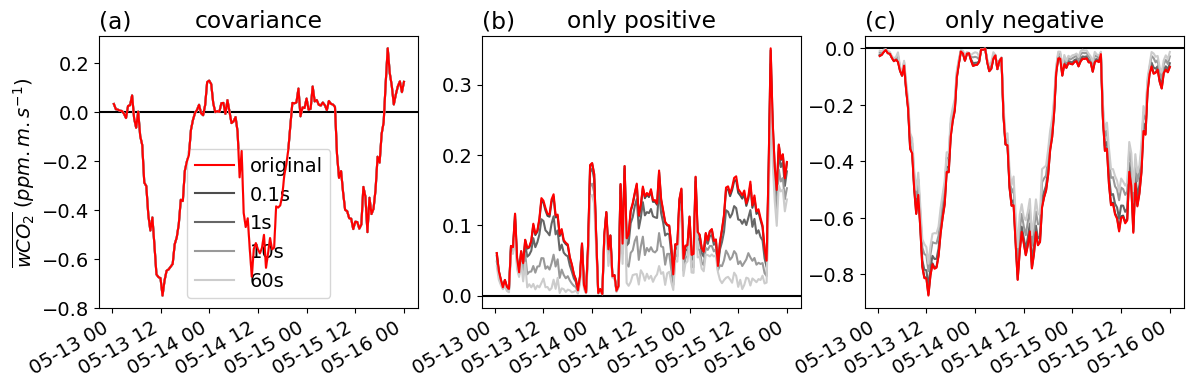

In [ ]:
plt.rcParams.update({'font.size': 14})

fullraw_data = wl_data.data.copy()
# wl_data.data = corrraw_data.interpolate().dropna(axis=1, how='all').dropna()

# Average
fullraw_data['co2_.1'] = fullraw_data['co2'].groupby(
    wl_data.data.TIMESTAMP_ns.dt.floor('0.1s')).transform(np.nanmean)
fullraw_data['co2_1'] = fullraw_data['co2'].groupby(
    wl_data.data.TIMESTAMP_ns.dt.floor('1s')).transform(np.nanmean)
fullraw_data['co2_10'] = fullraw_data['co2'].groupby(
    wl_data.data.TIMESTAMP_ns.dt.floor('10s')).transform(np.nanmean)
fullraw_data['co2_60'] = fullraw_data['co2'].groupby(
    wl_data.data.TIMESTAMP_ns.dt.floor('60s')).transform(np.nanmean)

fs = [1/j2sj(j_, 20) for j_ in j]
f30 = len([j_ for j_ in j if j_ < 14.13575])

fullraw_data['wl_w'] = np.nansum(wl_data.w, 0)
fullraw_data['wl_co2'] = np.nansum(wl_data.co2, 0)
fullraw_data['wl_w_'] = np.nansum(wl_data.w[f30:], 0)

wl_wc = wl_data.w * wl_data.co2
fullraw_data['wl_wco2'] = np.nansum(wl_wc[:f30], 0)
fullraw_data['wl_wco2+'] = np.nansum(np.where(wl_wc > 0, wl_wc, 0)[:f30], 0)
fullraw_data['wl_wco2-'] = np.nansum(np.where(wl_wc < 0, wl_wc, 0)[:f30], 0)

# Averaging after wavelet transform and product wc [TEST 3]
wl_wc = np.array(pd.DataFrame((wl_data.w * wl_data.co2).T).groupby(
    wl_data.data.TIMESTAMP_ns.dt.floor('0.1s')).transform(np.nanmean)).T
wl_wv = np.array(pd.DataFrame((wl_data.w * wl_data.h2o).T).groupby(
    wl_data.data.TIMESTAMP_ns.dt.floor('0.1s')).transform(np.nanmean)).T
fullraw_data['wl_wco2_a'] = np.nansum(wl_wc[:f30], 0)
fullraw_data['wl_wco2+_a'] = np.nansum(
    np.where((wl_wc > 0), wl_wc, 0)[:f30], 0)
fullraw_data['wl_wco2-_a'] = np.nansum(
    np.where((wl_wc < 0), wl_wc, 0)[:f30], 0)
wl_wc = np.array(pd.DataFrame((wl_data.w * wl_data.co2).T).groupby(
    wl_data.data.TIMESTAMP_ns.dt.floor('1s')).transform(np.nanmean)).T
wl_wv = np.array(pd.DataFrame((wl_data.w * wl_data.h2o).T).groupby(
    wl_data.data.TIMESTAMP_ns.dt.floor('1s')).transform(np.nanmean)).T
fullraw_data['wl_wco2_b'] = np.nansum(wl_wc[:f30], 0)
fullraw_data['wl_wco2+_b'] = np.nansum(
    np.where((wl_wc > 0), wl_wc, 0)[:f30], 0)
fullraw_data['wl_wco2-_b'] = np.nansum(
    np.where((wl_wc < 0), wl_wc, 0)[:f30], 0)
wl_wc = np.array(pd.DataFrame((wl_data.w * wl_data.co2).T).groupby(
    wl_data.data.TIMESTAMP_ns.dt.floor('10s')).transform(np.nanmean)).T
wl_wv = np.array(pd.DataFrame((wl_data.w * wl_data.h2o).T).groupby(
    wl_data.data.TIMESTAMP_ns.dt.floor('10s')).transform(np.nanmean)).T
fullraw_data['wl_wco2_c'] = np.nansum(wl_wc[:f30], 0)
fullraw_data['wl_wco2+_c'] = np.nansum(
    np.where((wl_wc > 0), wl_wc, 0)[:f30], 0)
fullraw_data['wl_wco2-_c'] = np.nansum(
    np.where((wl_wc < 0), wl_wc, 0)[:f30], 0)
wl_wc = np.array(pd.DataFrame((wl_data.w * wl_data.co2).T).groupby(
    wl_data.data.TIMESTAMP_ns.dt.floor('60s')).transform(np.nanmean)).T
wl_wv = np.array(pd.DataFrame((wl_data.w * wl_data.h2o).T).groupby(
    wl_data.data.TIMESTAMP_ns.dt.floor('60s')).transform(np.nanmean)).T
fullraw_data['wl_wco2_d'] = np.nansum(wl_wc[:f30], 0)
fullraw_data['wl_wco2+_d'] = np.nansum(
    np.where((wl_wc > 0), wl_wc, 0)[:f30], 0)
fullraw_data['wl_wco2-_d'] = np.nansum(
    np.where((wl_wc < 0), wl_wc, 0)[:f30], 0)

thisraw_data = wl_data.data.copy()
thisdate = "2022-05-13 15:30:00"
thisdate = pd.to_datetime(thisdate)
thisraw_data = thisraw_data.query(f'TIMESTAMP == "{thisdate}"')
thisraw_data = thisraw_data[16000: 20000]
thisraw_data = thisraw_data.reset_index(drop=True)
thisraw_data.index += 16000

plt.subplots(1, 3, figsize=(14, 4))

plt.subplot(131)
plt.title('(a)', loc='left')
plt.title('covariance')
plt.axhline(0, c='k')
fullraw_data.groupby('TIMESTAMP')['wl_wco2'].agg(np.nanmean).reset_index(drop=False).rename(columns={'wl_wco2': 'original'}).plot(
    x='TIMESTAMP', ax=plt.gca(), c='r', zorder=9)
fullraw_data.groupby('TIMESTAMP')['wl_wco2_a'].agg(np.nanmean).reset_index(drop=False).rename(columns={'wl_wco2_a': '0.1s'}).plot(
    x='TIMESTAMP', ax=plt.gca(), c='0.3')
fullraw_data.groupby('TIMESTAMP')['wl_wco2_b'].agg(np.nanmean).reset_index(drop=False).rename(columns={'wl_wco2_b': '1s'}).plot(
    x='TIMESTAMP', ax=plt.gca(), c='0.4')
fullraw_data.groupby('TIMESTAMP')['wl_wco2_c'].agg(np.nanmean).reset_index(drop=False).rename(columns={'wl_wco2_c': '10s'}).plot(
    x='TIMESTAMP', ax=plt.gca(), c='0.6')
fullraw_data.groupby('TIMESTAMP')['wl_wco2_d'].agg(np.nanmean).reset_index(drop=False).rename(columns={'wl_wco2_d': '60s'}).plot(
    x='TIMESTAMP', ax=plt.gca(), c='0.8')
plt.ylabel(r'$\overline{wCO_2}$ ($ppm.m.s^{-1}$)')
plt.legend()
plt.xlabel('')

plt.subplot(132)
plt.title('(b)', loc='left')
plt.title('only positive')
plt.axhline(0, c='k')
fullraw_data.groupby('TIMESTAMP')['wl_wco2+'].agg(np.nanmean).reset_index(drop=False).rename(columns={'wl_wco2+': 'original'}).plot(
    x='TIMESTAMP', ax=plt.gca(), c='r', zorder=9)
fullraw_data.groupby('TIMESTAMP')['wl_wco2+_a'].agg(np.nanmean).reset_index(drop=False).rename(columns={'wl_wco2+_a': '0.1s'}).plot(
    x='TIMESTAMP', ax=plt.gca(), c='0.3')
fullraw_data.groupby('TIMESTAMP')['wl_wco2+_b'].agg(np.nanmean).reset_index(drop=False).rename(columns={'wl_wco2+_b': '1s'}).plot(
    x='TIMESTAMP', ax=plt.gca(), c='0.4')
fullraw_data.groupby('TIMESTAMP')['wl_wco2+_c'].agg(np.nanmean).reset_index(drop=False).rename(columns={'wl_wco2+_c': '10s'}).plot(
    x='TIMESTAMP', ax=plt.gca(), c='0.6')
fullraw_data.groupby('TIMESTAMP')['wl_wco2+_d'].agg(np.nanmean).reset_index(drop=False).rename(columns={'wl_wco2+_d': '60s'}).plot(
    x='TIMESTAMP', ax=plt.gca(), c='0.8')
plt.legend().remove()
plt.xlabel('')

plt.subplot(133)
plt.title('(c)', loc='left')
plt.title('only negative')
plt.axhline(0, c='k')
fullraw_data.groupby('TIMESTAMP')['wl_wco2-'].agg(np.nanmean).reset_index(drop=False).rename(columns={'wl_wco2-': 'original'}).plot(
    x='TIMESTAMP', ax=plt.gca(), c='r', zorder=9)
fullraw_data.groupby('TIMESTAMP')['wl_wco2-_a'].agg(np.nanmean).reset_index(drop=False).rename(columns={'wl_wco2-_a': '0.1s'}).plot(
    x='TIMESTAMP', ax=plt.gca(), c='0.3')
fullraw_data.groupby('TIMESTAMP')['wl_wco2-_b'].agg(np.nanmean).reset_index(drop=False).rename(columns={'wl_wco2-_b': '1s'}).plot(
    x='TIMESTAMP', ax=plt.gca(), c='0.4')
fullraw_data.groupby('TIMESTAMP')['wl_wco2-_c'].agg(np.nanmean).reset_index(drop=False).rename(columns={'wl_wco2-_c': '10s'}).plot(
    x='TIMESTAMP', ax=plt.gca(), c='0.6')
fullraw_data.groupby('TIMESTAMP')['wl_wco2-_d'].agg(np.nanmean).reset_index(drop=False).rename(columns={'wl_wco2-_d': '60s'}).plot(
    x='TIMESTAMP', ax=plt.gca(), c='0.8')
plt.legend().remove()
plt.xlabel('')

plt.show()

CO2-H2O similarity

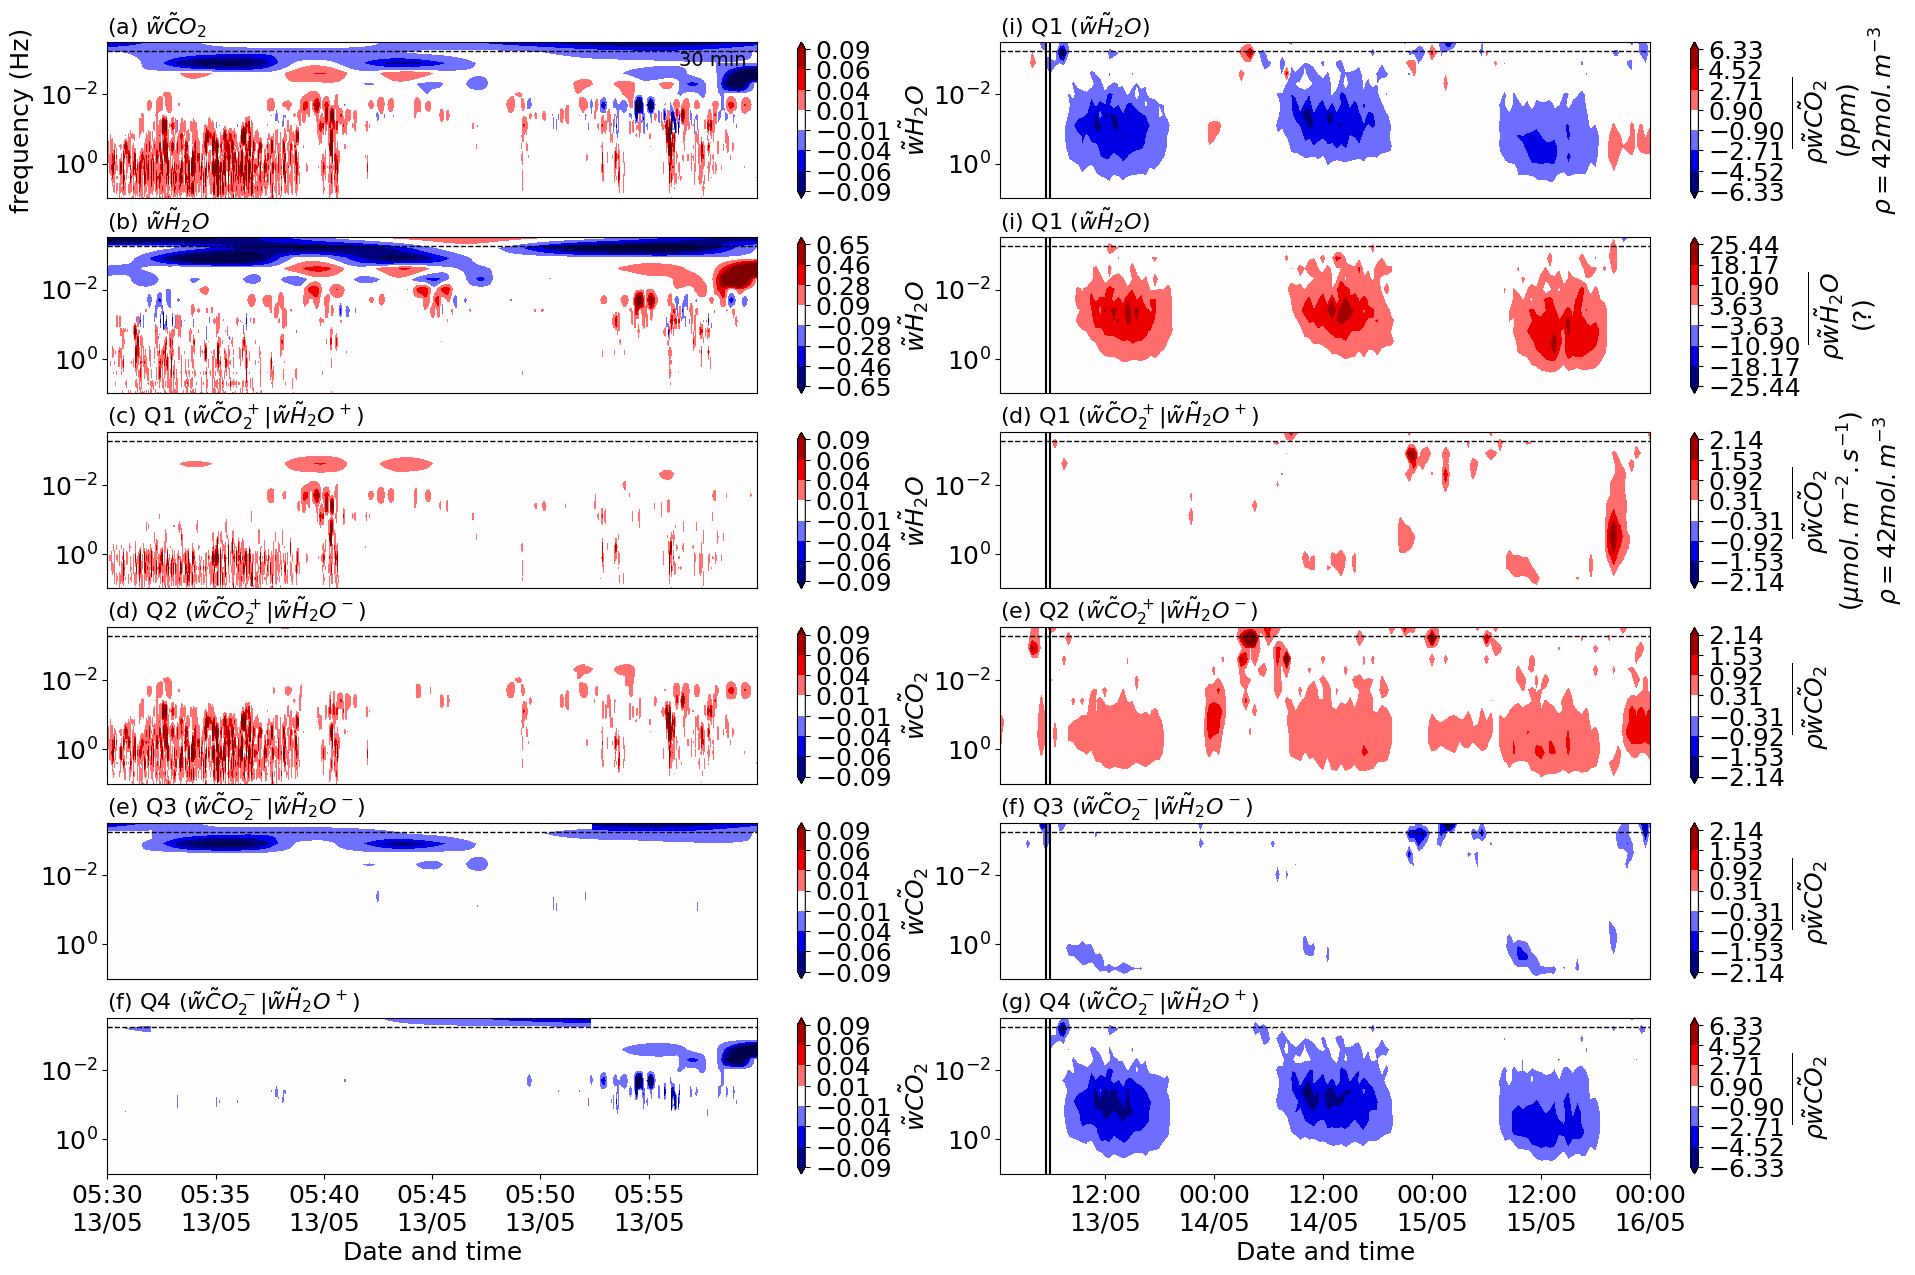

In [ ]:
plt.rcParams.update({'font.size': 18})
thisraw_data = wl_data.data.copy()

fs = [1/j2sj(j_, 20) for j_ in wl_data.sj]
Xi, Yi = np.meshgrid(wl_data.data.TIMESTAMP_ns.values, fs)

plt.subplots(6, 2, figsize=(22, 14.7),
             # gridspec_kw={'height_ratios': [3, 3, 3, 3, 3, 3]}
             )
plt.subplots_adjust(wspace=0.1, hspace=0.25)

i0 = 10
i1 = 11
cM = 2
pM = .95
norm = None  # .SymLogNorm(.5) .PowerNorm(2) .LogNorm(1, 2)#

plt.subplot(621)
plt.title(r"(a) $\~w\~CO_2$", loc='left', size=16)
plt.annotate('30 min', xy=(0.88, 0.85),
             xycoords='axes fraction', size=14)  # make it smaller
plt.axhline(1/(60*60*.5), c='k', lw=1, ls='--')

Zj = (wl_data.w*wl_data.co2)[:-1, int(i0*36000):int(i1*36000)]
levelsCO2 = np.linspace(-np.quantile(abs(Zj[:14]), pM)
                        * cM, np.quantile(abs(Zj[:14]), pM) * cM, 8).round(2)
plt.contourf(Xi[:-1, int(i0*36000):int(i1*36000)], Yi[:-1, int(i0*36000):int(i1*36000)],
             Zj, cmap=plt.cm.seismic, vmin=min(levelsCO2), vmax=max(levelsCO2), levels=levelsCO2, extend='both')
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('frequency (Hz)')
plt.xticks([])
plt.xlabel('')
plt.colorbar().set_label(r"$\~w\~H_2O$", rotation=90)

plt.subplot(623)
plt.title(r"(b) $\~w\~H_2O$", loc='left', size=16)
plt.axhline(1/(60*60*.5), c='k', lw=1, ls='--')
Zj = (wl_data.w*wl_data.h2o)[:-1, int(i0*36000):int(i1*36000)]
levelsH2O = np.linspace(-np.quantile(abs(Zj[:14]), pM)
                        * cM, np.quantile(abs(Zj[:14]), pM) * cM, 8).round(2)
plt.contourf(Xi[:-1, int(i0*36000):int(i1*36000)], Yi[:-1, int(i0*36000):int(i1*36000)],
             Zj, cmap=plt.cm.seismic, vmin=min(levelsH2O), vmax=max(levelsH2O), levels=levelsH2O, extend='both')
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.xticks([])
plt.xlabel('')
plt.colorbar().set_label(r"$\~w\~H_2O$", rotation=90)

plt.subplot(625)
plt.title(r'(c) Q1 ($\~w\~CO_2^+|\~w\~H_2O^+$)', loc='left', size=16)
plt.axhline(1/(60*60*.5), c='k', lw=1, ls='--')
cond = ((wl_data.w * wl_data.co2) > 0) * \
    ((wl_data.w * wl_data.h2o) > 0)
Zj = np.where(cond, wl_data.w * wl_data.co2,
              0)[:-1, int(i0*36000):int(i1*36000)]
plt.contourf(Xi[:-1, int(i0*36000):int(i1*36000)], Yi[:-1, int(i0*36000):int(i1*36000)],
             # np.where(cond, wl_data.w * wl_co2, -1)[:-1, int(i0*36000):int(i1*36000)], cmap=plt.cm.Reds, levels=np.linspace(0, .4, 8).round(2), extend='max')
             Zj, cmap=plt.cm.seismic, vmin=min(levelsCO2), vmax=max(levelsCO2), levels=levelsCO2, extend='both')
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.colorbar().set_label(r"$\~w\~H_2O$", rotation=90)
plt.xticks([])
plt.xlabel('')

plt.subplot(627)
plt.title(r'(d) Q2 ($\~w\~CO_2^+|\~w\~H_2O^-$)', loc='left', size=16)
plt.axhline(1/(60*60*.5), c='k', lw=1, ls='--')
cond = ((wl_data.w * wl_data.co2) > 0) * \
    ((wl_data.w * wl_data.h2o) < 0)
Zj = np.where(cond, wl_data.w * wl_data.co2,
              0)[:-1, int(i0*36000):int(i1*36000)]
plt.contourf(Xi[:-1, int(i0*36000):int(i1*36000)], Yi[:-1, int(i0*36000):int(i1*36000)],
             # np.where(cond, wl_data.w * wl_co2, -1)[:-1, int(i0*36000):int(i1*36000)], cmap=plt.cm.Reds, levels=np.linspace(0, .4, 8).round(2), extend='max')
             Zj, cmap=plt.cm.seismic, vmin=min(levelsCO2), vmax=max(levelsCO2), levels=levelsCO2, extend='both')
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.colorbar().set_label(r"$\~w\~{CO}_2$")
plt.xticks([])
plt.xlabel('')

plt.subplot(629)
plt.title(r'(e) Q3 ($\~w\~CO_2^-|\~w\~H_2O^-$)', loc='left', size=16)
plt.axhline(1/(60*60*.5), c='k', lw=1, ls='--')
cond = ((wl_data.w * wl_data.co2) < 0) * \
    ((wl_data.w * wl_data.h2o) < 0)
Zj = np.where(cond, wl_data.w * wl_data.co2,
              0)[:-1, int(i0*36000):int(i1*36000)]
plt.contourf(Xi[:-1, int(i0*36000):int(i1*36000)], Yi[:-1, int(i0*36000):int(i1*36000)],
             # np.where(cond, wl_data.w * wl_co2, -1)[:-1, int(i0*36000):int(i1*36000)], cmap=plt.cm.Blues_r, levels=np.linspace(-2., 0, 18).round(2), extend='min')
             Zj, cmap=plt.cm.seismic, vmin=min(levelsCO2), vmax=max(levelsCO2), levels=levelsCO2, extend='both')
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.colorbar().set_label(r"$\~w\~{CO}_2$")
plt.xticks([])
plt.xlabel('')

plt.subplot(6,2,11)
plt.title(r'(f) Q4 ($\~w\~CO_2^-|\~w\~H_2O^+$)', loc='left', size=16)
plt.axhline(1/(60*60*.5), c='k', lw=1, ls='--')
cond = ((wl_data.w * wl_data.co2) < 0) * \
    ((wl_data.w * wl_data.h2o) > 0)
Zj = np.where(cond, wl_data.w * wl_data.co2,
              0)[:-1, int(i0*36000):int(i1*36000)]
plt.contourf(Xi[:-1, int(i0*36000):int(i1*36000)], Yi[:-1, int(i0*36000):int(i1*36000)],
             # np.where(cond, wl_data.w * wl_co2, -1)[:-1, int(i0*36000):int(i1*36000)], cmap=plt.cm.Blues_r, levels=np.linspace(-2., 0, 18).round(2), extend='min')
             Zj, cmap=plt.cm.seismic, vmin=min(levelsCO2), vmax=max(levelsCO2), levels=levelsCO2, extend='both')
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M\n%d/%m'))
plt.xlabel('Date and time')
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.colorbar().set_label(r"$\~w\~{CO}_2$")

##############################################################################################################


plt.subplot(622)
plt.title(r'(i) Q1 ($\~w\~H_2O$)', loc='left', size=16)
plt.axhline(1/(60*60*.5), c='k', lw=1, ls='--')
plt.axvline(min(Xi[0, int(i0*36000):int(i1*36000)]), c='k')
plt.axvline(max(Xi[0, int(i0*36000):int(i1*36000)]), c='k')
Xj, Yj = np.meshgrid(thisraw_data.TIMESTAMP.unique(), fs)
# assuming density of dry air ~ 42 mol/m3
Zj = pd.concat([thisraw_data['TIMESTAMP'], 42 * pd.DataFrame((wl_data.w * wl_data.co2).T)], axis=1).groupby('TIMESTAMP').agg(np.nanmean).values.T
levelsCO2 = np.linspace(-np.quantile(abs(Zj[:14]), pM)
                        * cM, np.quantile(abs(Zj[:14]), pM) * cM, 8).round(2)
levelsCO2_ = np.linspace(-np.quantile(abs(Zj[:14]), 0.75)
                        * cM, np.quantile(abs(Zj[:14]), 0.75) * cM, 8).round(2)
plt.contourf(Xj[:-1], Yj[:-1], Zj[:-1], vmin=min(levelsCO2), vmax=max(levelsCO2),
             cmap=plt.cm.seismic, norm=norm, levels=levelsCO2, extend='both')
# plt.contourf(Xj[:-1], Yj[:-1], Zj[:-1], vmin=-np.quantile(abs(Zj[:14]), .99) * cM, vmax=np.quantile(abs(Zj[:14]), .99) * cM, cmap=plt.cm.seismic, norm=norm)
plt.xticks([])
plt.xlabel('')
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.colorbar().set_label(
    r"$ρ\overline{\~w\~{CO}_2}$"+"\n"+r"($ppm$)"+"\n"+r"$ρ=42mol.m^{-3}$")

plt.subplot(624)
plt.title(r'(i) Q1 ($\~w\~H_2O$)', loc='left', size=16)
plt.axhline(1/(60*60*.5), c='k', lw=1, ls='--')
plt.axvline(min(Xi[0, int(i0*36000):int(i1*36000)]), c='k')
plt.axvline(max(Xi[0, int(i0*36000):int(i1*36000)]), c='k')
Xj, Yj = np.meshgrid(thisraw_data.TIMESTAMP.unique(), fs)
# assuming density of dry air ~ 42 mol/m3
Zj = pd.concat([thisraw_data['TIMESTAMP'], pd.DataFrame((wl_data.w * wl_data.h2o).T)], axis=1).groupby('TIMESTAMP').agg(np.nanmean).values.T
levelsH2O = np.linspace(-np.quantile(abs(Zj[:14]), pM)
                        * cM, np.quantile(abs(Zj[:14]), pM) * cM, 8).round(3)
plt.contourf(Xj[:-1], Yj[:-1], Zj[:-1], vmin=min(levelsH2O), vmax=max(levelsH2O),
             cmap=plt.cm.seismic, norm=norm, levels=levelsH2O, extend='both')
# plt.contourf(Xj[:-1], Yj[:-1], Zj[:-1], vmin=-np.quantile(abs(Zj[:14]), .99) * cM, vmax=np.quantile(abs(Zj[:14]), .99) * cM, cmap=plt.cm.seismic, norm=norm)
plt.xticks([])
plt.xlabel('')
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.colorbar().set_label(
    r"$ρ\overline{\~w\~{H}_2O}$"+"\n"+r"($?$)")

plt.subplot(626)
plt.title(r'(d) Q1 ($\~w\~CO_2^+|\~w\~H_2O^+$)', loc='left', size=16)
plt.axhline(1/(60*60*.5), c='k', lw=1, ls='--')
plt.axvline(min(Xi[0, int(i0*36000):int(i1*36000)]), c='k')
plt.axvline(max(Xi[0, int(i0*36000):int(i1*36000)]), c='k')
Xj, Yj = np.meshgrid(thisraw_data.TIMESTAMP.unique(), fs)
# assuming density of dry air ~ 42 mol/m3
cond = ((wl_data.w * wl_data.co2) > 0) * \
    ((wl_data.w * wl_data.h2o) > 0)
Zj = pd.concat([thisraw_data['TIMESTAMP'], 42 * pd.DataFrame(np.where(cond,
               wl_data.w * wl_data.co2, 0).T)], axis=1).groupby('TIMESTAMP').agg(np.nanmean).values.T
#levels = np.linspace(0, np.quantile(abs(Zj[:14]), pM) * cM, 8).round(2)
plt.contourf(Xj[:-1], Yj[:-1], Zj[:-1], vmin=min(levelsCO2_), vmax=max(levelsCO2_),
             cmap=plt.cm.seismic, norm=norm, levels=levelsCO2_, extend='both')
# plt.contourf(Xj[:-1], Yj[:-1], Zj[:-1], vmin=-np.quantile(abs(Zj[:14]), .99) * cM, vmax=np.quantile(abs(Zj[:14]), .99) * cM, cmap=plt.cm.seismic, norm=norm)
plt.xticks([])
plt.xlabel('')
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.colorbar().set_label(
    r"$ρ\overline{\~w\~{CO}_2}$"+"\n"+r"($μmol.m^{-2}.s^{-1}$)"+"\n"+r"$ρ=42mol.m^{-3}$")

plt.subplot(628)
plt.title(r'(e) Q2 ($\~w\~CO_2^+|\~w\~H_2O^-$)', loc='left', size=16)
plt.axhline(1/(60*60*.5), c='k', lw=1, ls='--')
plt.axvline(min(Xi[0, int(i0*36000):int(i1*36000)]), c='k')
plt.axvline(max(Xi[0, int(i0*36000):int(i1*36000)]), c='k')
cond = ((wl_data.w * wl_data.co2) > 0) * \
    ((wl_data.w * wl_data.h2o) < 0)
Zj = pd.concat([thisraw_data['TIMESTAMP'], 42 * pd.DataFrame(np.where(cond,
               wl_data.w * wl_data.co2, 0).T)], axis=1).groupby('TIMESTAMP').agg(np.nanmean).values.T
# levels = np.linspace(0, np.quantile(abs(Zj[:14]), pM) * cM, 8).round(2)
plt.contourf(Xj[:-1], Yj[:-1], Zj[:-1], vmin=min(levelsCO2_), vmax=max(levelsCO2_),
             cmap=plt.cm.seismic, norm=norm, levels=levelsCO2_, extend='both')
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.colorbar().set_label(r"$ρ\overline{\~w\~{CO}_2}$")
plt.xticks([])
plt.xlabel('')

plt.subplot(6, 2, 10)
plt.title(r'(f) Q3 ($\~w\~CO_2^-|\~w\~H_2O^-$)', loc='left', size=16)
plt.axhline(1/(60*60*.5), c='k', lw=1, ls='--')
plt.axvline(min(Xi[0, int(i0*36000):int(i1*36000)]), c='k')
plt.axvline(max(Xi[0, int(i0*36000):int(i1*36000)]), c='k')
cond = ((wl_data.w * wl_data.co2) < 0) * \
    ((wl_data.w * wl_data.h2o) < 0)
Zj = pd.concat([thisraw_data['TIMESTAMP'], 42 * pd.DataFrame(np.where(cond,
               wl_data.w * wl_data.co2, 0).T)], axis=1).groupby('TIMESTAMP').agg(np.nanmean).values.T
# levels = np.linspace(-np.quantile(abs(Zj[:14]), pM) * cM, 0, 8).round(2)
plt.contourf(Xj[:-1], Yj[:-1], Zj[:-1], vmin=min(levelsCO2_), vmax=max(levelsCO2_),
             cmap=plt.cm.seismic, norm=norm, levels=levelsCO2_, extend='both')
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.colorbar().set_label(r"$ρ\overline{\~w\~{CO}_2}$")
plt.xticks([])
plt.xlabel('')

plt.subplot(6, 2, 12)
plt.title(r'(g) Q4 ($\~w\~CO_2^-|\~w\~H_2O^+$)', loc='left', size=16)
plt.axhline(1/(60*60*.5), c='k', lw=1, ls='--')
plt.axvline(min(Xi[0, int(i0*36000):int(i1*36000)]), c='k')
plt.axvline(max(Xi[0, int(i0*36000):int(i1*36000)]), c='k')
cond = ((wl_data.w * wl_data.co2) < 0) * ((wl_data.w * wl_data.h2o) > 0)
Zj = pd.concat([thisraw_data['TIMESTAMP'], 42 * pd.DataFrame(np.where(cond,
               wl_data.w * wl_data.co2, 0).T)], axis=1).groupby('TIMESTAMP').agg(np.nanmean).values.T
# levels = np.linspace(-np.quantile(abs(Zj[:14]), pM) * cM, 0, 8).round(2)
plt.contourf(Xj[:-1], Yj[:-1], Zj[:-1], vmin=min(levelsCO2), vmax=max(levelsCO2),
             cmap=plt.cm.seismic, norm=norm, levels=levelsCO2, extend='both')
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M\n%d/%m'))
plt.xlabel('Date and time')
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.colorbar().set_label(r"$ρ\overline{\~w\~{CO}_2}$")

plt.show()

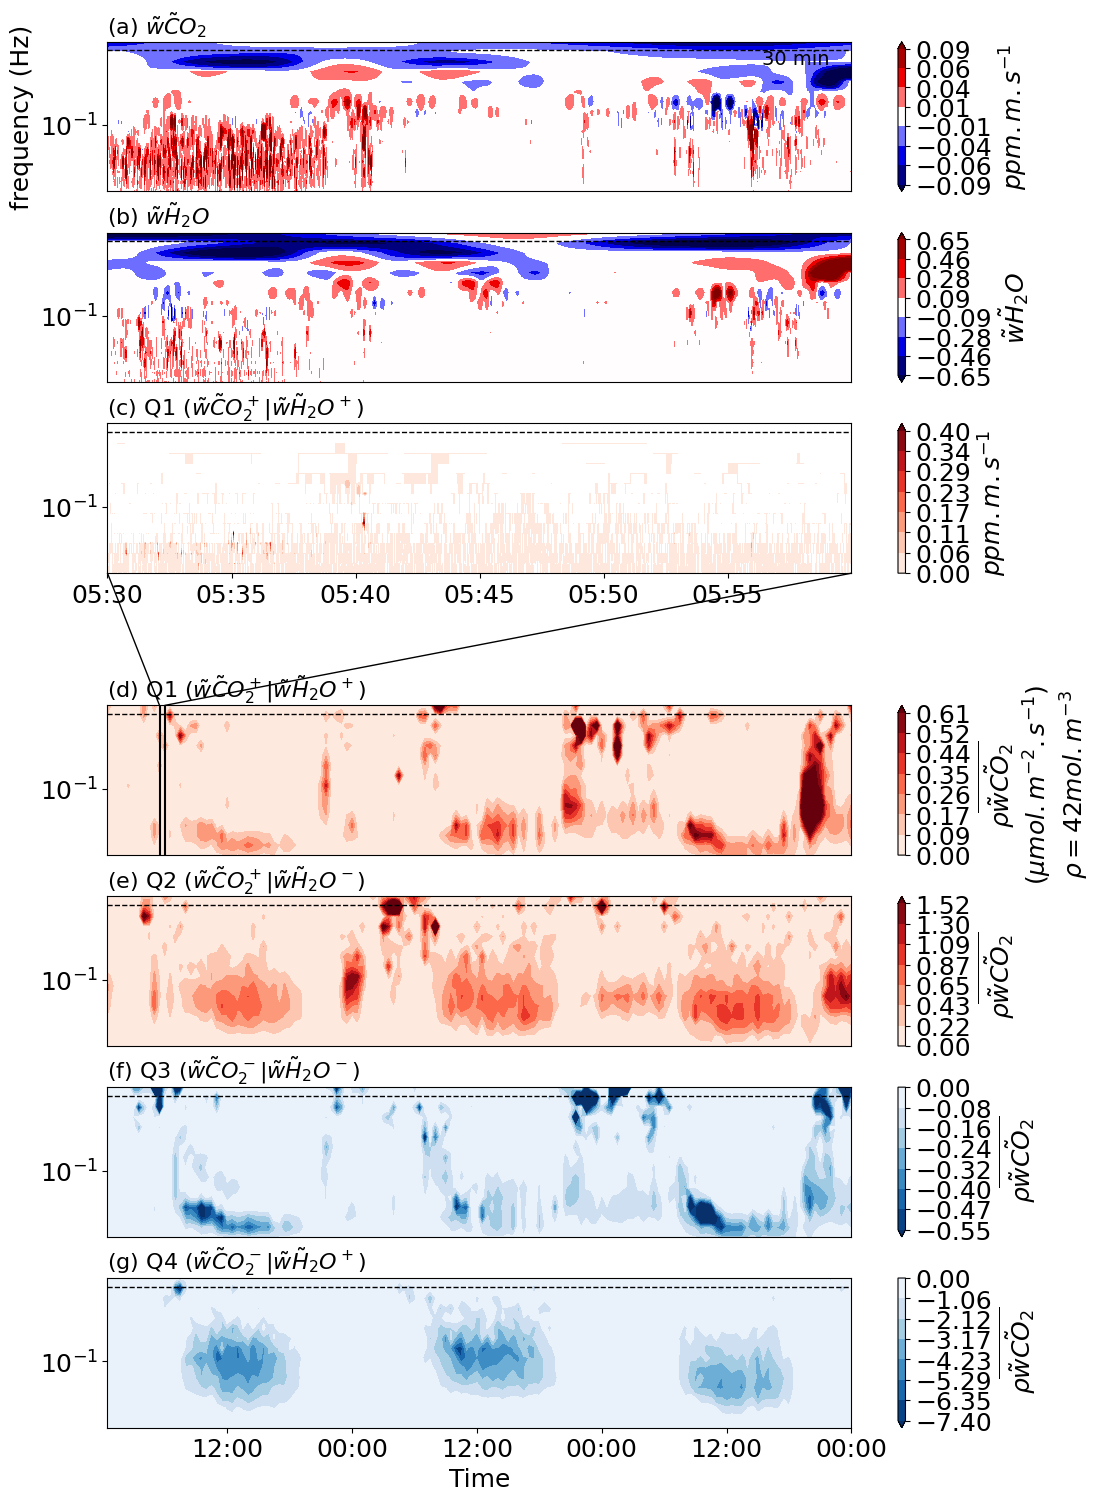

In [ ]:
plt.rcParams.update({'font.size': 18})

thisraw_data = wl_data.data.copy()
fs = [1/j2sj(j_, 20) for j_ in wl_data.sj]
Xi, Yi = np.meshgrid(thisraw_data.TIMESTAMP_ns.values, fs)

plt.subplots(8, 1, figsize=(12, 18), gridspec_kw={
             'height_ratios': [3, 3, 3, 1, 3, 3, 3, 3]})
plt.subplots_adjust(wspace=0, hspace=0.3)
i0 = 10
i1 = 11
cM = 2
pM = .95
norm = None # .SymLogNorm(.5) .PowerNorm(2) .LogNorm(1, 2)#

plt.subplot(811)
plt.title(r"(a) $\~w\~CO_2$", loc='left', size=16)
plt.annotate('30 min', xy=(0.88, 0.85),
             xycoords='axes fraction', size=14)  # make it smaller
plt.axhline(1/(60*60*.5), c='k', lw=1, ls='--')
Zj = (wl_data.w*wl_data.co2)[:-1, int(i0*36000):int(i1*36000)]
levels = np.linspace(-np.quantile(abs(Zj[:14]), pM)
                     * cM, np.quantile(abs(Zj[:14]), pM) * cM, 8).round(2)
plt.contourf(Xi[:-1, int(i0*36000):int(i1*36000)], Yi[:-1, int(i0*36000):int(i1*36000)],
             Zj, cmap=plt.cm.seismic, vmin=min(levels), vmax=max(levels), levels=levels, extend='both')
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('frequency (Hz)')
plt.xticks([])
plt.xlabel('')
plt.colorbar().set_label(r"$ppm.m.s^{-1}$", rotation=90)

plt.subplot(812)
plt.title(r"(b) $\~w\~H_2O$", loc='left', size=16)
plt.axhline(1/(60*60*.5), c='k', lw=1, ls='--')
Zj = (wl_data.w*wl_data.h2o)[:-1, int(i0*36000):int(i1*36000)]
levels = np.linspace(-np.quantile(abs(Zj[:14]), pM)
                     * cM, np.quantile(abs(Zj[:14]), pM) * cM, 8).round(2)
plt.contourf(Xi[:-1, int(i0*36000):int(i1*36000)], Yi[:-1, int(i0*36000):int(i1*36000)],
             Zj, cmap=plt.cm.seismic, vmin=min(levels), vmax=max(levels), levels=levels, extend='both')
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.xticks([])
plt.xlabel('')
plt.colorbar().set_label(r"$\~w\~H_2O$", rotation=90)
lastax = plt.gca()

plt.subplot(813)
plt.title(r'(c) Q1 ($\~w\~CO_2^+|\~w\~H_2O^+$)', loc='left', size=16)
plt.axhline(1/(60*60*.5), c='k', lw=1, ls='--')
cond = ((wl_data.w * wl_data.co2)>0) * ((wl_data.w * wl_data.h2o)>0)
plt.contourf(Xi[:-1, int(i0*36000):int(i1*36000)], Yi[:-1, int(i0*36000):int(i1*36000)], 
             np.where(cond, wl_data.w * wl_data.co2, -1)[:-1, int(i0*36000):int(i1*36000)], cmap=plt.cm.Reds, levels=np.linspace(0, .4, 8).round(2), extend='max')
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.colorbar().set_label(r"$ppm.m.s^{-1}$", rotation=90)
lastax = plt.gca()

plt.subplot(814)
plt.gca().axis('off')

plt.subplot(815)
plt.title(r'(d) Q1 ($\~w\~CO_2^+|\~w\~H_2O^+$)', loc='left', size=16)
plt.axhline(1/(60*60*.5), c='k', lw=1, ls='--')
plt.axvline(min(Xi[0, int(i0*36000):int(i1*36000)]), c='k')
plt.axvline(max(Xi[0, int(i0*36000):int(i1*36000)]), c='k')
Xj, Yj = np.meshgrid(thisraw_data.TIMESTAMP.unique(), fs)
# assuming density of dry air ~ 42 mol/m3 
cond = ((wl_data.w * wl_data.co2)>0) * ((wl_data.w * wl_data.h2o)>0)
Zj = pd.concat([thisraw_data['TIMESTAMP'], 42 * pd.DataFrame(np.where(cond,
               wl_data.w * wl_data.co2, 0).T)], axis=1).groupby('TIMESTAMP').agg(np.nanmean).values.T
levels = np.linspace(0, np.quantile(abs(Zj[:14]), pM) * cM, 8).round(2)
plt.contourf(Xj[:-1], Yj[:-1], Zj[:-1], vmin=min(levels), vmax=max(levels), cmap=plt.cm.Reds, norm=norm, levels=levels, extend='max')
#plt.contourf(Xj[:-1], Yj[:-1], Zj[:-1], vmin=-np.quantile(abs(Zj[:14]), .99) * cM, vmax=np.quantile(abs(Zj[:14]), .99) * cM, cmap=plt.cm.seismic, norm=norm)
plt.xticks([])
plt.xlabel('')
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.colorbar().set_label(r"$ρ\overline{\~w\~{CO}_2}$"+"\n"+r"($μmol.m^{-2}.s^{-1}$)"+"\n"+r"$ρ=42mol.m^{-3}$")

from matplotlib.patches import ConnectionPatch
con = ConnectionPatch(xyA=(min(Xi[0, int(i0*36000):int(i1*36000)]),plt.gca().get_ylim()[1]), xyB=(0,0), coordsA="data", coordsB="axes fraction",
                      axesA=plt.gca(), axesB=lastax, color="k")
plt.gca().add_artist(con)
con = ConnectionPatch(xyA=(max(Xi[0, int(i0*36000):int(i1*36000)]),plt.gca().get_ylim()[1]), xyB=(1,0), coordsA="data", coordsB="axes fraction",
                      axesA=plt.gca(), axesB=lastax, color="k")
plt.gca().add_artist(con)

plt.subplot(816)
plt.title(r'(e) Q2 ($\~w\~CO_2^+|\~w\~H_2O^-$)', loc='left', size=16)
plt.axhline(1/(60*60*.5), c='k', lw=1, ls='--')
cond = ((wl_data.w * wl_data.co2)>0) * ((wl_data.w * wl_data.h2o)<0)
Zj = pd.concat([thisraw_data['TIMESTAMP'], 42 * pd.DataFrame(np.where(cond, wl_data.w * wl_data.co2, 0).T)], axis=1).groupby('TIMESTAMP').agg(np.nanmean).values.T
levels = np.linspace(0, np.quantile(abs(Zj[:14]), pM) * cM, 8).round(2)
plt.contourf(Xj[:-1], Yj[:-1], Zj[:-1], vmin=min(levels), vmax=max(levels), cmap=plt.cm.Reds, norm=norm, levels=levels, extend='max')
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.colorbar().set_label(r"$ρ\overline{\~w\~{CO}_2}$")
plt.xticks([])
plt.xlabel('')

plt.subplot(817)
plt.title(r'(f) Q3 ($\~w\~CO_2^-|\~w\~H_2O^-$)', loc='left', size=16)
plt.axhline(1/(60*60*.5), c='k', lw=1, ls='--')
cond = ((wl_data.w * wl_data.co2)<0) * ((wl_data.w * wl_data.h2o)<0)
Zj = pd.concat([thisraw_data['TIMESTAMP'], 42 * pd.DataFrame(np.where(cond, wl_data.w *
               wl_data.co2, 0).T)], axis=1).groupby('TIMESTAMP').agg(np.nanmean).values.T
levels = np.linspace(-np.quantile(abs(Zj[:14]), pM) * cM, 0, 8).round(2)
plt.contourf(Xj[:-1], Yj[:-1], Zj[:-1], vmin=min(levels), vmax=max(levels), cmap=plt.cm.Blues_r, norm=norm, levels=levels, extend='min')
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.colorbar().set_label(r"$ρ\overline{\~w\~{CO}_2}$")
plt.xticks([])
plt.xlabel('')

plt.subplot(818)
plt.title(r'(g) Q4 ($\~w\~CO_2^-|\~w\~H_2O^+$)', loc='left', size=16)
plt.axhline(1/(60*60*.5), c='k', lw=1, ls='--')
cond = ((wl_data.w * wl_data.co2) < 0) * \
    ((wl_data.w * wl_data.h2o) > 0)
Zj = pd.concat([thisraw_data['TIMESTAMP'], 42 * pd.DataFrame(np.where(cond, wl_data.w *
               wl_data.co2, 0).T)], axis=1).groupby('TIMESTAMP').agg(np.nanmean).values.T
levels = np.linspace(-np.quantile(abs(Zj[:14]), pM) * cM, 0, 8).round(2)
plt.contourf(Xj[:-1], Yj[:-1], Zj[:-1], vmin=min(levels), vmax=max(levels), cmap=plt.cm.Blues_r, norm=norm, levels=levels, extend='min')
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M')) #\n%d/%m'))
plt.xlabel('Time')
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.colorbar().set_label(r"$ρ\overline{\~w\~{CO}_2}$")

plt.show()

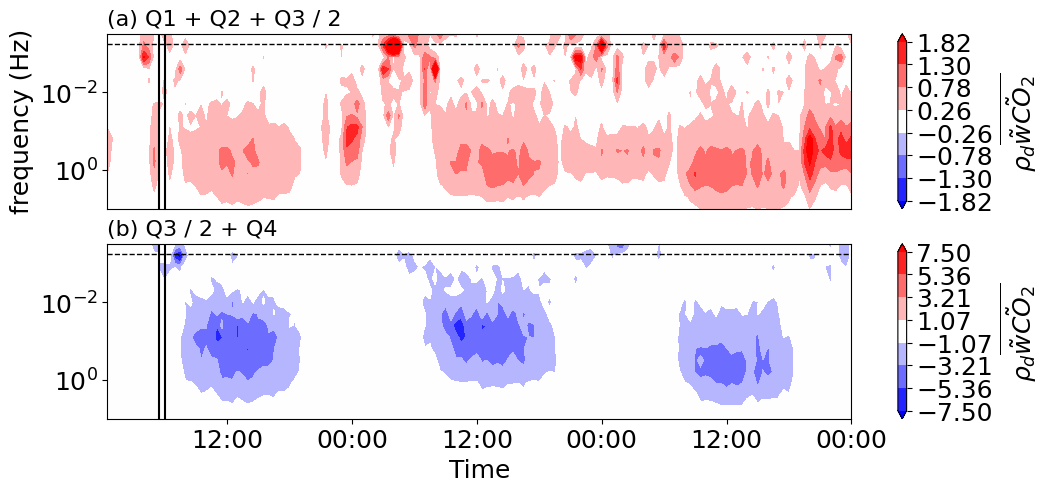

In [ ]:
# import os
# if 'current_file_folder' not in globals(): current_file_folder = os.getcwd()
# os.chdir(current_file_folder+'/../..')
# from waveletec._core import wavelet_functions
# from waveletec import _core as hc24
# if 'current_file_folder' in globals(): os.chdir(current_file_folder)
# from matplotlib import pyplot as plt
# from matplotlib.dates import DateFormatter
# import matplotlib
# import numpy as np
plt.rcParams.update({'font.size': 18})

thisraw_data = wl_data.data.copy()
# thisraw_data = corrraw_data.interpolate().dropna(axis=1, how='all').dropna()
# wl_data.w = wEC.wavelet_transform(thisraw_data.w.to_list(), 'dwt', wavelet='db6', fs=20, f0=1/(3*60*60), f1=10, fn=180, 
#                  dj=1/12, inv=True)
# wl_co2 = wEC.wavelet_transform(thisraw_data.co2.to_list(), 'dwt', wavelet='db6', fs=20, f0=1/(3*60*60), f1=10, fn=180, 
#                  dj=1/12, inv=True)
# wl_data.h2o = wEC.wavelet_transform(thisraw_data.h2o.to_list(), 'dwt', wavelet='db6', fs=20, f0=1/(3*60*60), f1=10, fn=180, 
#                  dj=1/12, inv=True)
fs = [1/j2sj(j_, 20) for j_ in wl_data.sj]
Xi, Yi = np.meshgrid(thisraw_data.TIMESTAMP_ns.values, fs)
Xj, Yj = np.meshgrid(thisraw_data.TIMESTAMP.unique(), fs)
wco2 = wl_data.w * wl_data.co2
wh2o = wl_data.w * wl_data.h2o

plt.subplots(2,1, figsize=(12, 5), gridspec_kw={'height_ratios': [3,3]})
i0 = 10
i1 = 11
cM = 2
pM = .95
norm = None # .SymLogNorm(.5) .PowerNorm(2) .LogNorm(1, 2)#

plt.subplot(211)
plt.title('(a) Q1 + Q2 + Q3 / 2', loc='left', size=16)
plt.axhline(1/(60*60*.5), c='k', lw=1, ls='--')
plt.axvline(min(Xi[0, int(i0*36000):int(i1*36000)]), c='k')
plt.axvline(max(Xi[0, int(i0*36000):int(i1*36000)]), c='k')
cond = (((wco2) > 0)) #| (((wco2) < 0) * ((wh2o) < 0))
Zj = wco2
# Zj = np.where((((wco2) < 0) * ((wh2o) < 0)), (wco2) / 2, wco2)
Zj = pd.concat([thisraw_data['TIMESTAMP'], 42 * pd.DataFrame(np.where(cond, Zj, 0).T)], axis=1).groupby('TIMESTAMP').agg(np.nanmean).values.T
levels = np.linspace(-np.quantile(abs(Zj[:14]), pM) * cM, np.quantile(abs(Zj[:14]), pM) * cM, 8).round(2)
plt.contourf(Xj[:-1], Yj[:-1], Zj[:-1], vmin=min(levels), vmax=max(levels), cmap=plt.cm.bwr, norm=norm, levels=levels, extend='both')
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('frequency (Hz)')
plt.colorbar().set_label(r"$ρ_d\overline{\~w\~{CO}_2}$")
plt.xticks([])
plt.xlabel('')

plt.subplot(212)
plt.title('(b) Q3 / 2 + Q4', loc='left', size=16)
plt.axhline(1/(60*60*.5), c='k', lw=1, ls='--')
plt.axvline(min(Xi[0, int(i0*36000):int(i1*36000)]), c='k')
plt.axvline(max(Xi[0, int(i0*36000):int(i1*36000)]), c='k')
cond = (((wco2) < 0)) # (((wco2) < 0) * ((wh2o) > 0)) #| (((wco2) < 0) * ((wh2o) < 0))
Zj = wco2
# Zj = np.where((((wco2) < 0) * ((wh2o) < 0)), (wco2) / 2, wco2)
Zj = pd.concat([thisraw_data['TIMESTAMP'], 42 * pd.DataFrame(np.where(cond, Zj, 0).T)], axis=1).groupby('TIMESTAMP').agg(np.nanmean).values.T
levels = np.linspace(-np.quantile(abs(Zj[:14]), pM) * cM, np.quantile(abs(Zj[:14]), pM) * cM, 8).round(2)
plt.contourf(Xj[:-1], Yj[:-1], Zj[:-1], vmin=min(levels), vmax=max(levels), cmap=plt.cm.bwr, norm=norm, levels=levels, extend='both')
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))#\n%d/%m'))
plt.xlabel('Time')
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.colorbar().set_label(r"$ρ_d\overline{\~w\~{CO}_2}$")

plt.show()


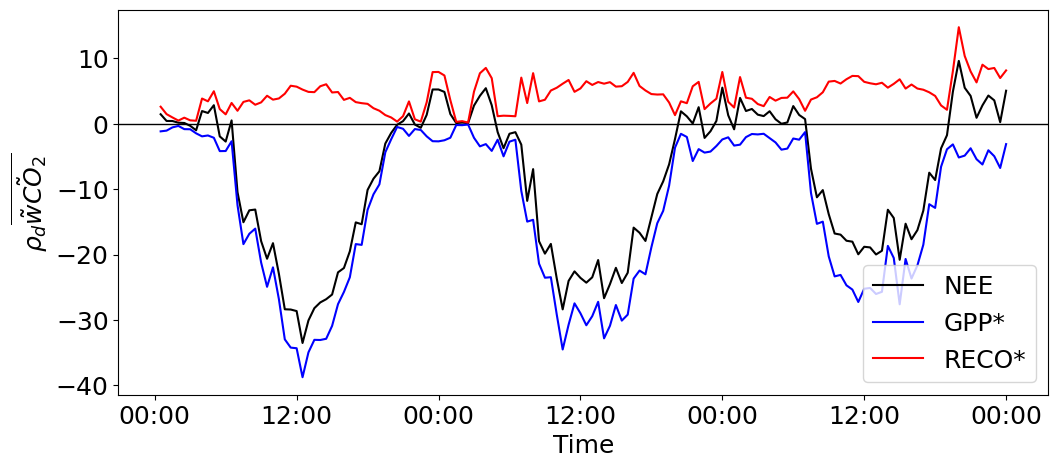

In [ ]:
plt.figure(figsize=(12, 5))

plt.title('', loc='left', size=16)
plt.axhline(0, c='k', lw=1)
# plt.axhline(1/(60*60*.5), c='k', lw=1, ls='--')
# plt.axvline(min(Xi[0, int(i0*36000):int(i1*36000)]), c='k')
# plt.axvline(max(Xi[0, int(i0*36000):int(i1*36000)]), c='k')

# (((wco2) < 0) * ((wh2o) > 0)) #| (((wco2) < 0) * ((wh2o) < 0))
cond = True
Zj = wco2
# Zj = np.where((((wco2) < 0) * ((wh2o) < 0)), (wco2) / 2, wco2)
Zj = pd.concat([thisraw_data['TIMESTAMP'], 42 * pd.DataFrame(np.where(cond,
               Zj, 0).T)], axis=1).groupby('TIMESTAMP').agg(np.nanmean)[range(15)].sum(axis=1)
plt.plot(Zj.index, Zj, c='k', label='NEE')

cond = (((wco2) < 0))
Zj = wco2
# Zj = np.where((((wco2) < 0) * ((wh2o) < 0)), (wco2) / 2, wco2)
Zj = pd.concat([thisraw_data['TIMESTAMP'], 42 * pd.DataFrame(np.where(cond,
               Zj, 0).T)], axis=1).groupby('TIMESTAMP').agg(np.nanmean)[range(15)].sum(axis=1)
plt.plot(Zj.index, Zj, c='b', label='GPP*')

cond = (((wco2) > 0))
Zj = wco2
# Zj = np.where((((wco2) < 0) * ((wh2o) < 0)), (wco2) / 2, wco2)
Zj = pd.concat([thisraw_data['TIMESTAMP'], 42 * pd.DataFrame(np.where(cond,
               Zj, 0).T)], axis=1).groupby('TIMESTAMP').agg(np.nanmean)[range(15)].sum(axis=1)
plt.plot(Zj.index, Zj, c='r', label='RECO*')

# cond = (((wco2) < 0) * ((wh2o) > 0))  # | (((wco2) < 0) * ((wh2o) < 0))
# Zj = wco2
# # Zj = np.where((((wco2) < 0) * ((wh2o) < 0)), (wco2) / 2, wco2)
# Zj = pd.concat([thisraw_data['TIMESTAMP'], 42 * pd.DataFrame(np.where(cond,
#                Zj, 0).T)], axis=1).groupby('TIMESTAMP').agg(np.nanmean)[range(15)].sum(axis=1)
# plt.plot(Zj.index, Zj, c='r')

# cond = (((wco2) < 0) * ((wh2o) > 0)) | (((wco2) < 0) * ((wh2o) < 0))
# Zj = wco2
# Zj = np.where((((wco2) < 0) * ((wh2o) < 0)), (wco2) / 2, wco2)
# Zj = pd.concat([thisraw_data['TIMESTAMP'], 42 * pd.DataFrame(np.where(cond,
#                Zj, 0).T)], axis=1).groupby('TIMESTAMP').agg(np.nanmean)[range(15)].sum(axis=1)
# plt.plot(Zj.index, Zj, c='b')


plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))  # \n%d/%m'))
plt.xlabel('Time')
plt.ylabel(r"$ρ_d\overline{\~w\~{CO}_2}$")
plt.legend()

# End